# Pronóstico de Ventas de Productos Estrella para Enero 2025

**Análisis de Series Temporales con Optimización Bayesiana y Protocolo de Validación Recursiva**

**Autor:** Juan Mosquera
**Fecha:** Noviembre 2024

---

## 📊 1. ENTENDIMIENTO DEL PROBLEMA

### 1.1 Contexto de Negocio

**Situación:**
- Una compañía de comestibles tiene **dos productos estrella** en su portafolio
- Estos productos son críticos para el negocio (alta rotación/margen)
- Necesitan pronósticos precisos para el **siguiente mes** (enero 2025)

**¿Por qué es importante?**
- **Planificación de inventario**: Evitar quiebres de stock o sobreinventario
- **Optimización de recursos**: Producción, logística, capital de trabajo
- **Decisiones estratégicas**: Promociones, pricing, expansión

**Impacto de un mal pronóstico:**
- Subestimar ventas → Pérdida de ventas, clientes insatisfechos
- Sobrestimar ventas → Inventario obsoleto, costos de almacenamiento

### 1.2 Análisis de los Datos de Entrada

**Dataset: Examen.csv**
- **Periodo**: Junio 2014 - Diciembre 2024 (127 meses = 10.5 años)
- **Variables**: 2 columnas (producto1, producto2)
- **Frecuencia**: Mensual
- **Calidad**: Sin valores nulos, datos continuos

**Pregunta Clave de Negocio:**
> *¿Cuántas unidades de cada producto debo planificar para enero 2025, con qué nivel de confianza, y qué factores de riesgo debo considerar?*

In [3]:
# Configuración e Importación de Librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from dateutil.relativedelta import relativedelta

# Librerías de modelado y evaluación
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA

from statsmodels.tsa.exponential_smoothing.ets import ETSModel
from statsmodels.stats.diagnostic import acorr_ljungbox
import statsmodels.api as sm

from sklearn.metrics import mean_squared_error, mean_absolute_error

import optuna

import os
os.environ['PYTHONWARNINGS'] = 'ignore'

sns.set_style("whitegrid")
# Configuraciones
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', category=UserWarning, module='tqdm')
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 7)
plt.rcParams['figure.dpi'] = 150

print("✓ Librerías importadas correctamente")

✓ Librerías importadas correctamente


## 2. CARGA Y EXPLORACIÓN INICIAL DE DATOS

In [4]:
# Carga de Datos y Verificación Inicial
df = pd.read_csv('Examen.csv', index_col=0)

# Crear índice de fechas mensual comenzando en Junio 2014
date_index = pd.date_range(start='2014-06-01', periods=len(df), freq='MS')
df.set_index(date_index, inplace=True)

# Verificar estructura
print("="*60)
print("ESTRUCTURA DEL DATASET")
print("="*60)
print(f"Periodo: {df.index.min().strftime('%b %Y')} - {df.index.max().strftime('%b %Y')}")
print(f"Total de observaciones: {len(df)} meses")
print(f"Columnas: {list(df.columns)}")
print(f"\nPrimeras 5 observaciones:")
print(df.head())
print(f"\nÚltimas 5 observaciones:")
print(df.tail())

# Verificar calidad de datos
print(f"\n{'='*60}")
print("VERIFICACIÓN DE CALIDAD")
print("="*60)
print(f"Valores nulos:\n{df.isnull().sum()}")
print(f"\nTipos de datos:\n{df.dtypes}")

ESTRUCTURA DEL DATASET
Periodo: Jun 2014 - Dec 2024
Total de observaciones: 127 meses
Columnas: ['producto1', 'producto2']

Primeras 5 observaciones:
             producto1   producto2
2014-06-01  500.000000  200.000000
2014-07-01  497.400893  210.686220
2014-08-01  478.605317  222.018584
2014-09-01  486.454125  233.920990
2014-10-01  479.695678  238.402098

Últimas 5 observaciones:
             producto1   producto2
2024-08-01  164.610771  629.293034
2024-09-01  150.881839  637.099467
2024-10-01  151.788470  653.155282
2024-11-01  137.047639  672.528345
2024-12-01  141.990873  676.058092

VERIFICACIÓN DE CALIDAD
Valores nulos:
producto1    0
producto2    0
dtype: int64

Tipos de datos:
producto1    float64
producto2    float64
dtype: object


In [5]:
# Estadísticas Descriptivas
stats_desc = df.describe().T
stats_desc['CV%'] = (stats_desc['std'] / stats_desc['mean']) * 100

print("="*60)
print("ESTADÍSTICAS DESCRIPTIVAS")
print("="*60)
print(stats_desc[['mean', 'std', 'min', 'max', 'CV%']].round(2))

# Calcular tendencias
from sklearn.linear_model import LinearRegression
X = np.arange(len(df)).reshape(-1, 1)

for col in df.columns:
    y = df[col].values
    lr = LinearRegression().fit(X, y)
    cambio_mes = lr.coef_[0]
    r2 = lr.score(X, y)
    print(f"\n{col}:")
    print(f"  - Cambio promedio mensual: {cambio_mes:.2f} unidades/mes")
    print(f"  - R² de tendencia lineal: {r2:.2f}")

ESTADÍSTICAS DESCRIPTIVAS
             mean     std     min     max    CV%
producto1  343.57  100.23  137.05  500.00  29.17
producto2  581.04  167.50  200.00  806.44  28.83

producto1:
  - Cambio promedio mensual: -2.38 unidades/mes
  - R² de tendencia lineal: 0.76

producto2:
  - Cambio promedio mensual: 3.83 unidades/mes
  - R² de tendencia lineal: 0.71


### 2.1 Visualización de Series Temporales Completas

**Figura 1**: Series temporales completas de ambos productos

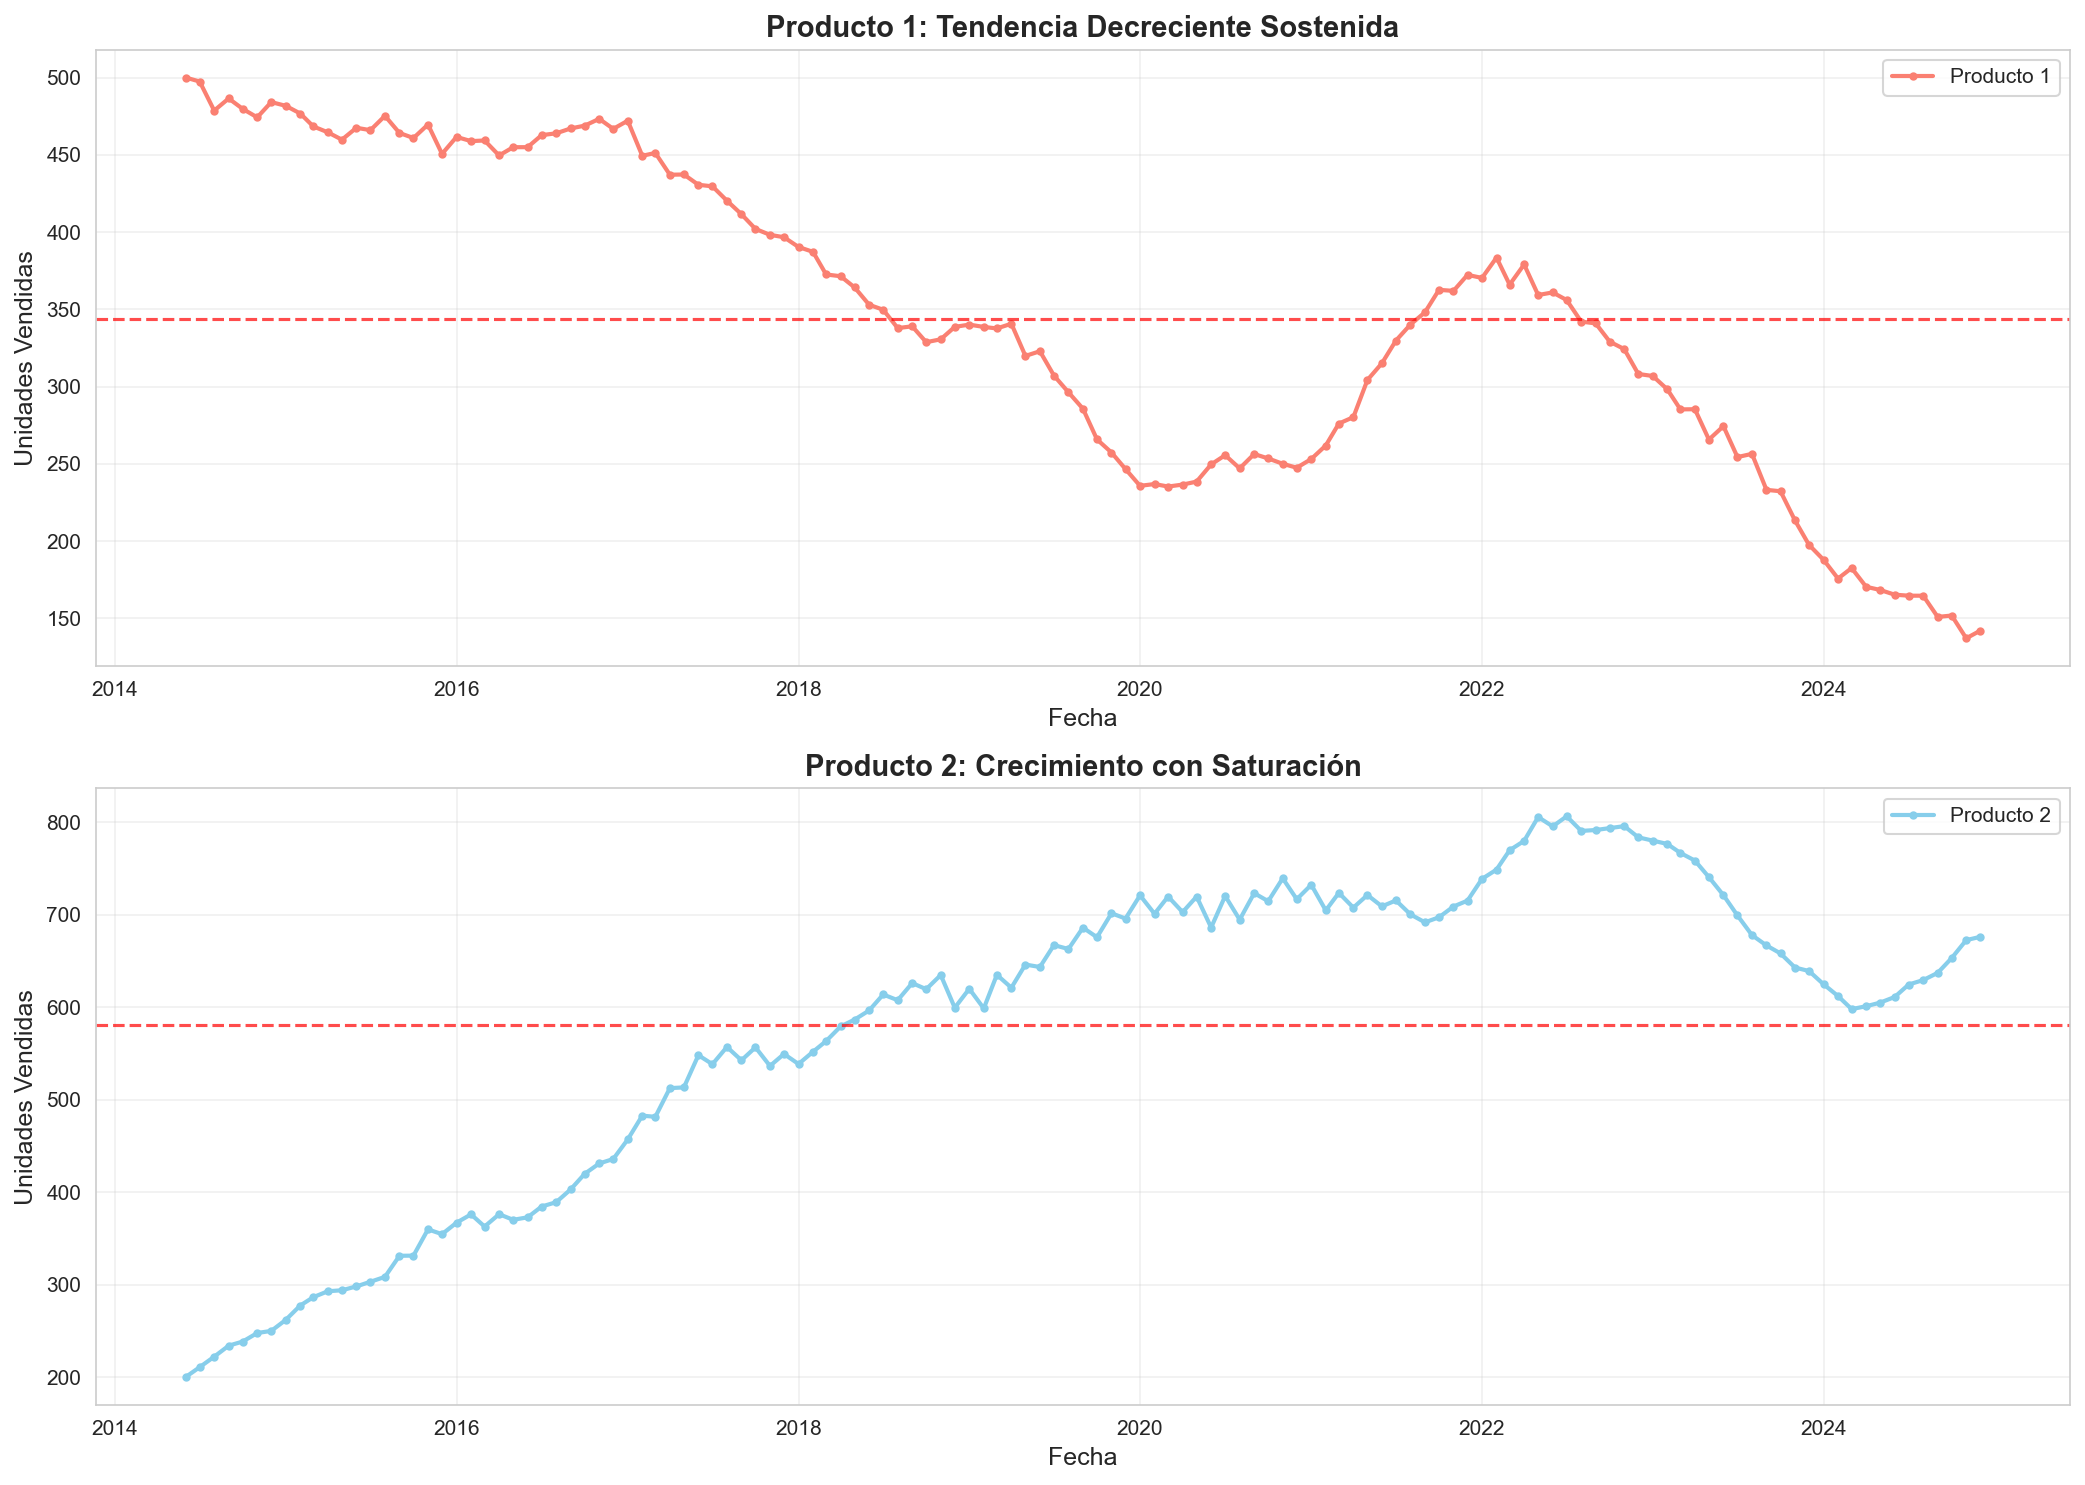

✓ Figura 1 guardada: fig1_series_completas.png


In [6]:
# Visualización de las Series Temporales
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))

# Producto 1
ax1.plot(df.index, df['producto1'], label='Producto 1', color='salmon', marker='o', 
         linestyle='-', linewidth=2, markersize=3)
ax1.set_title('Producto 1: Tendencia Decreciente Sostenida', fontsize=14, fontweight='bold')
ax1.set_xlabel('Fecha', fontsize=12)
ax1.set_ylabel('Unidades Vendidas', fontsize=12)
ax1.legend(loc='best', fontsize=10)
ax1.grid(True, alpha=0.3)
ax1.axhline(y=df['producto1'].mean(), color='red', linestyle='--', 
            label=f'Media: {df["producto1"].mean():.0f}', alpha=0.7)

# Producto 2
ax2.plot(df.index, df['producto2'], label='Producto 2', color='skyblue', marker='o', 
         linestyle='-', linewidth=2, markersize=3)
ax2.set_title('Producto 2: Crecimiento con Saturación', fontsize=14, fontweight='bold')
ax2.set_xlabel('Fecha', fontsize=12)
ax2.set_ylabel('Unidades Vendidas', fontsize=12)
ax2.legend(loc='best', fontsize=10)
ax2.grid(True, alpha=0.3)
ax2.axhline(y=df['producto2'].mean(), color='red', linestyle='--', 
            label=f'Media: {df["producto2"].mean():.0f}', alpha=0.7)

plt.tight_layout()
plt.savefig('outputs/fig1_series_completas.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Figura 1 guardada: fig1_series_completas.png")

### 2.2 Descomposición de Series Temporales

**Figura 2**: Descomposición en tendencia, estacionalidad y componente residual

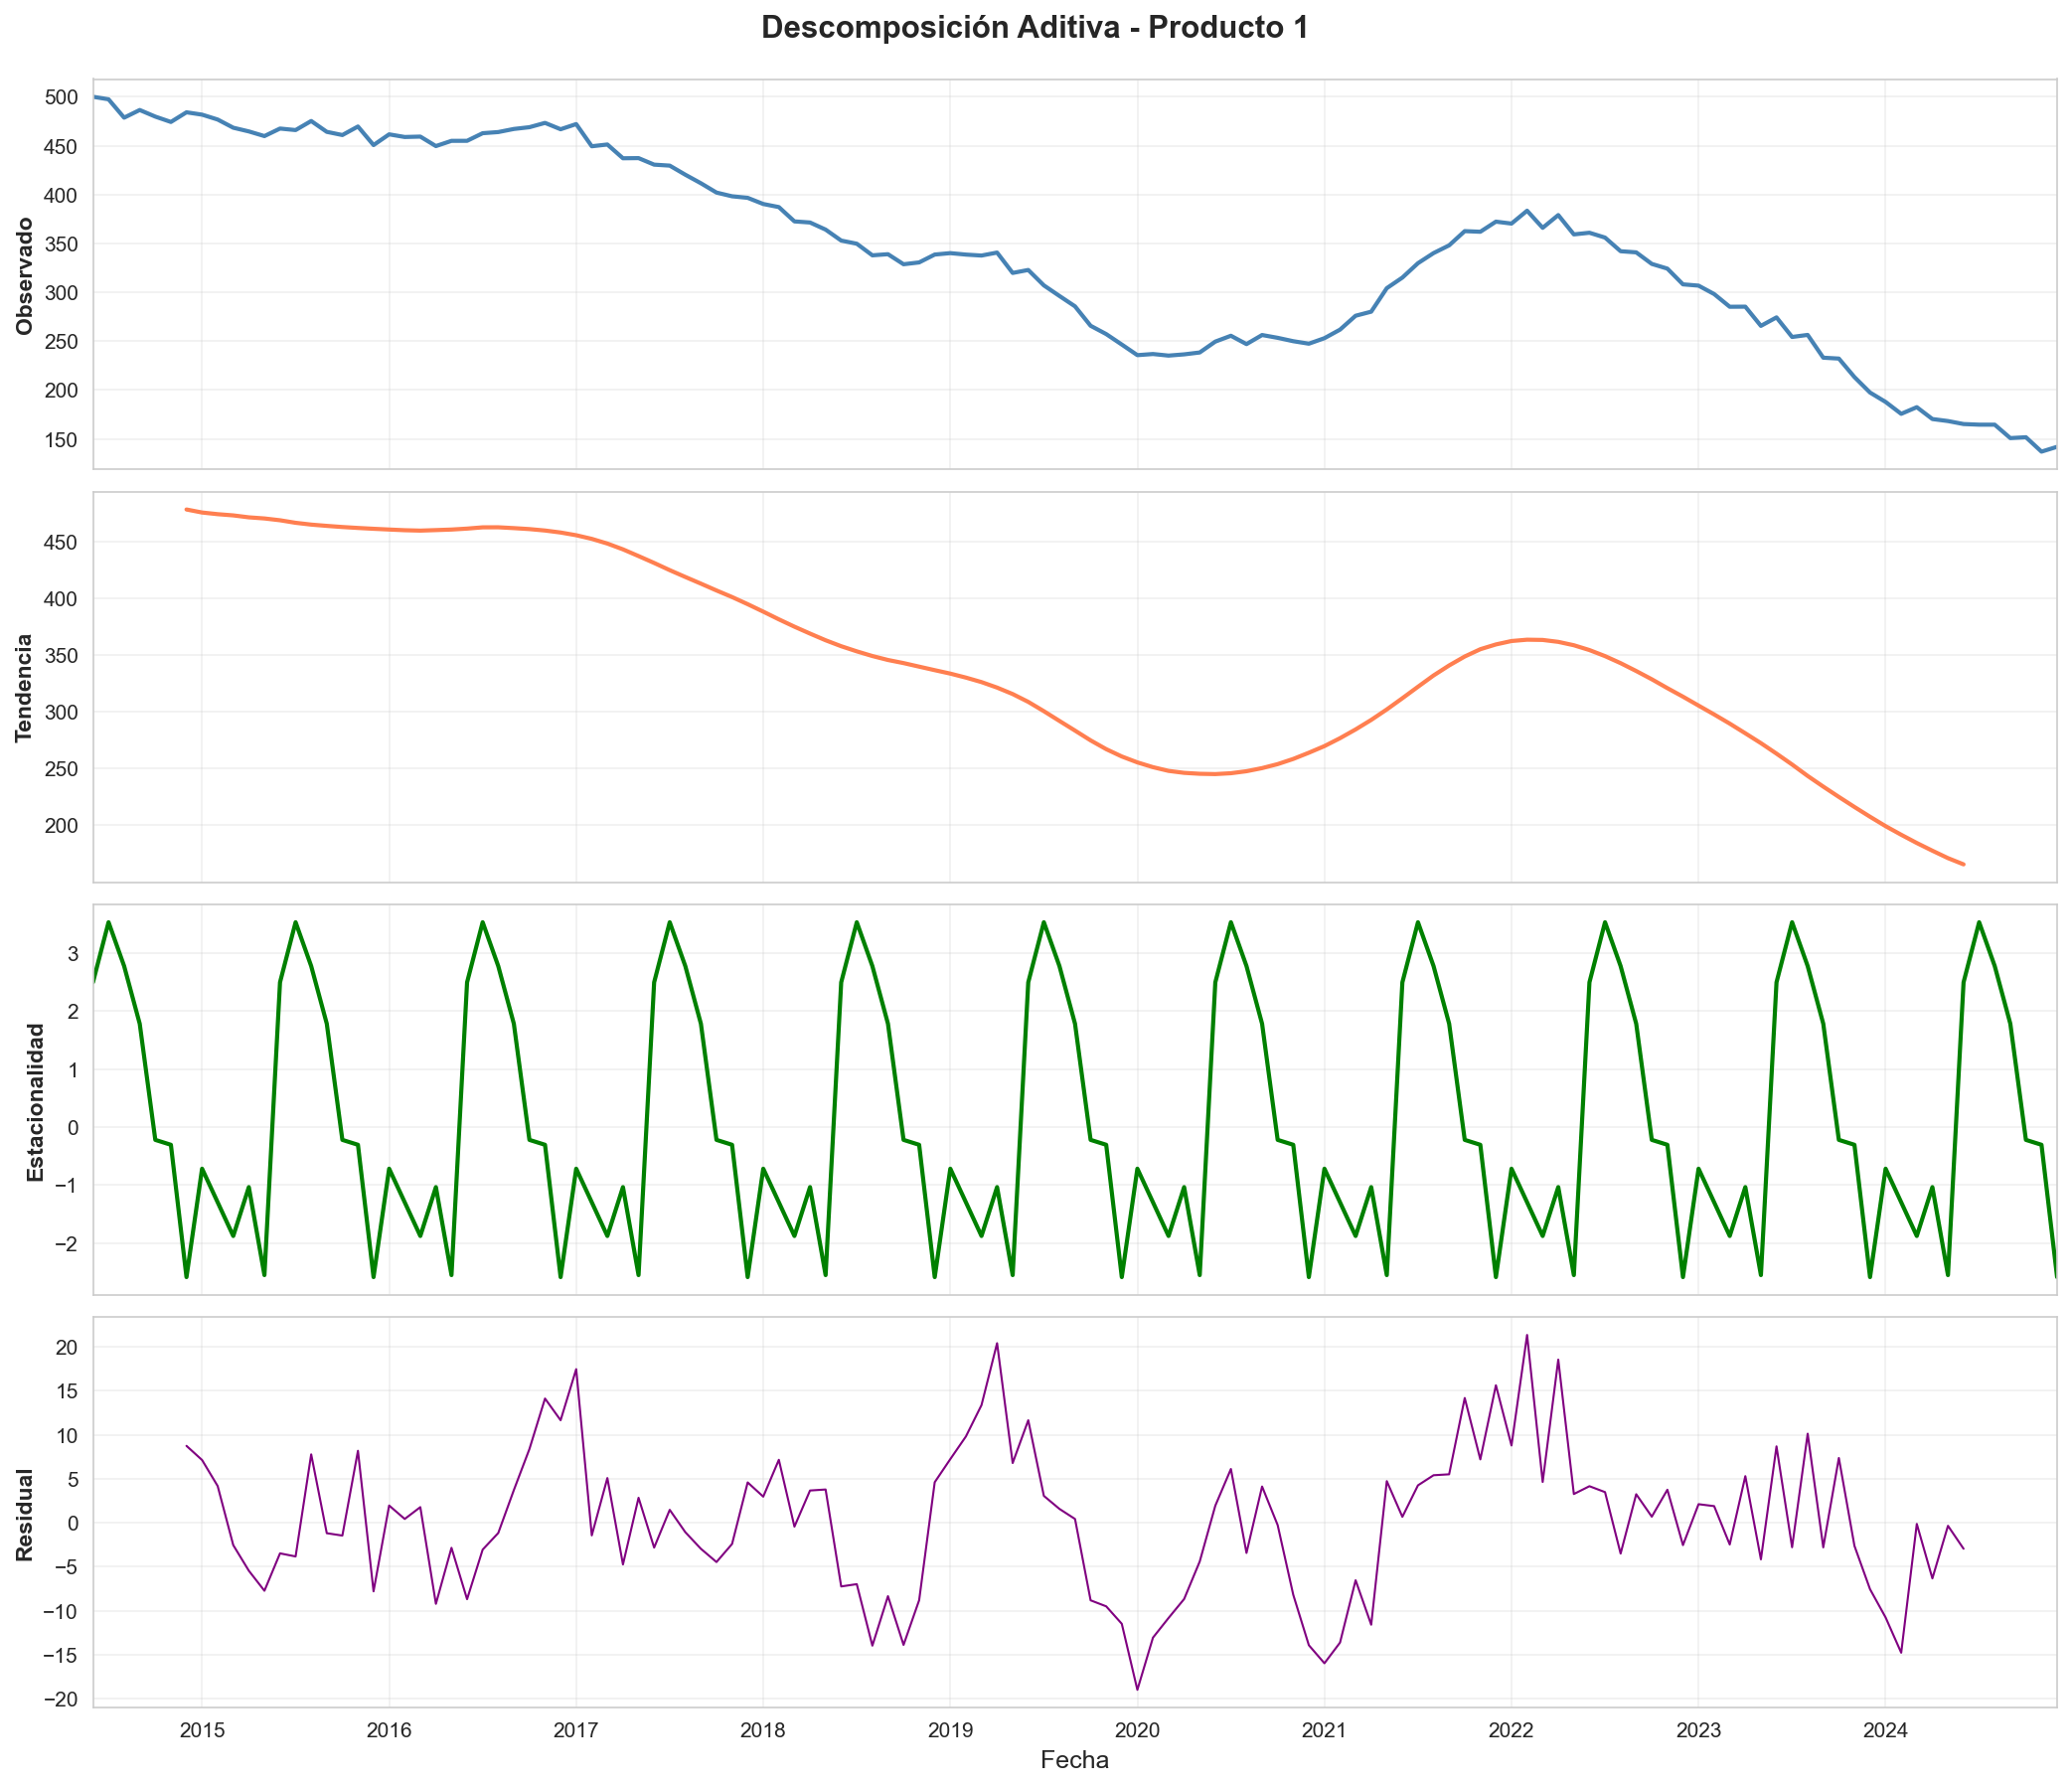

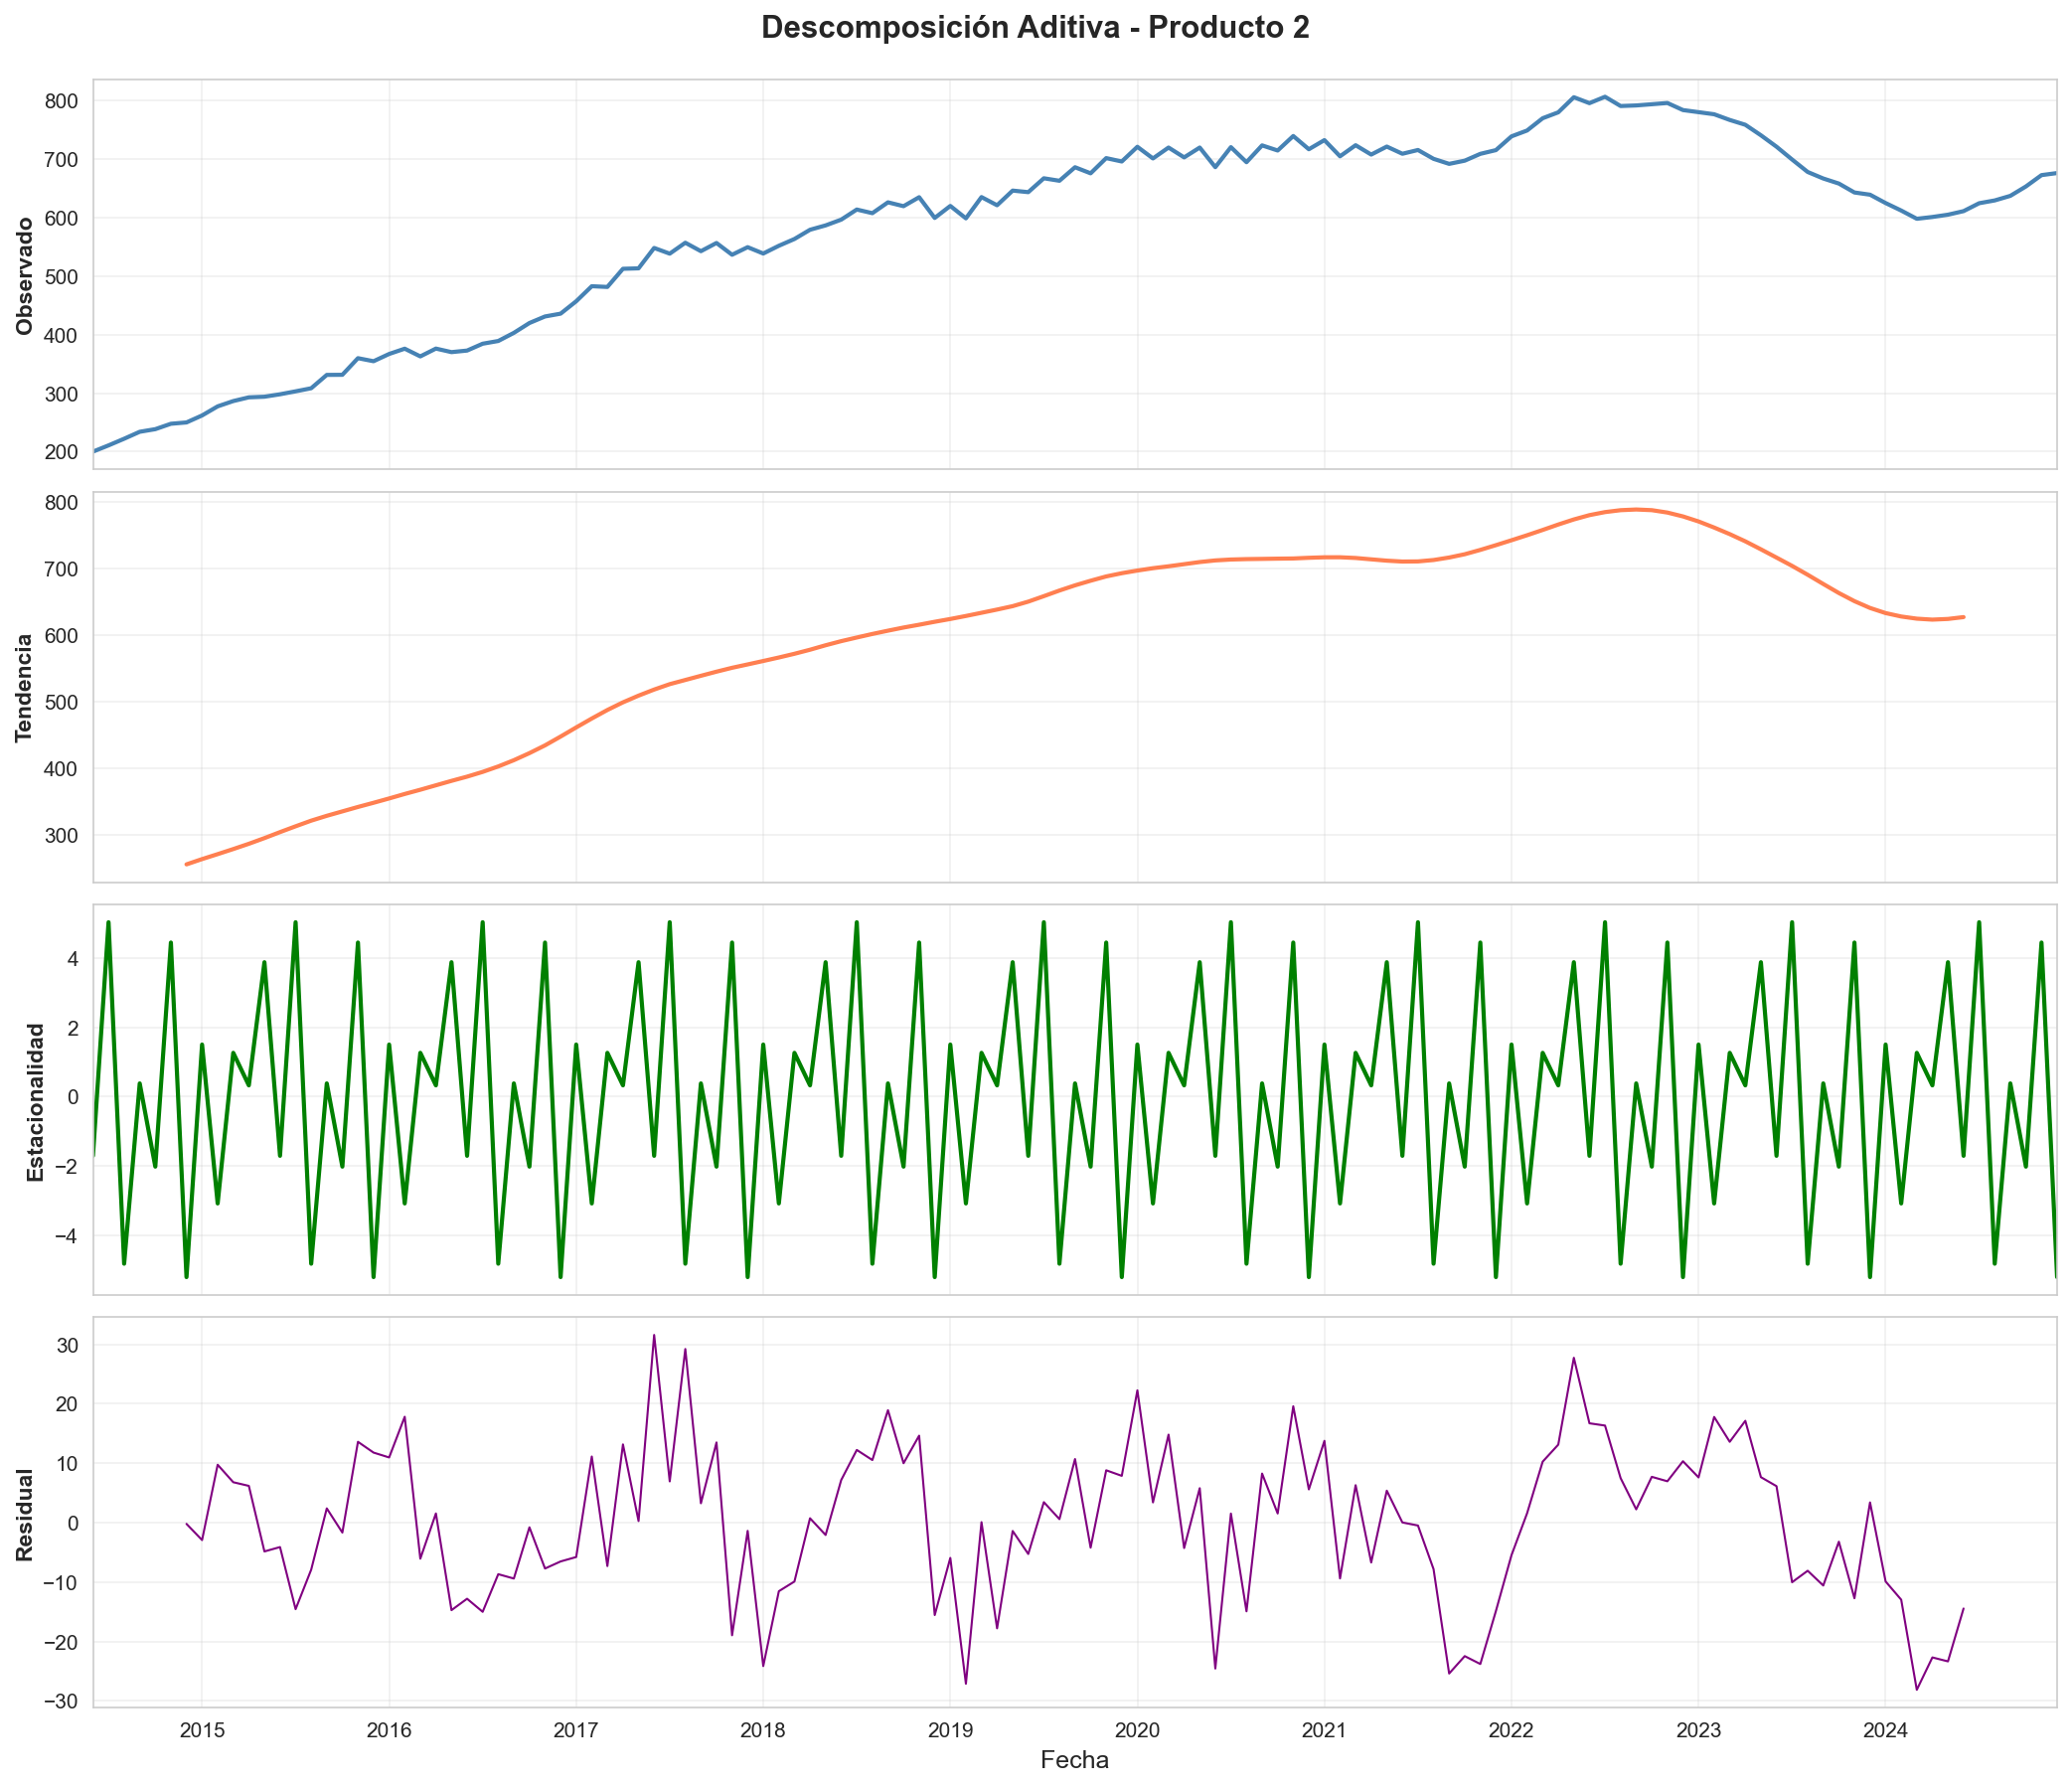

✓ Figuras 2a y 2b guardadas: descomposiciones


In [7]:
# Descomposición de las Series Temporales
def plot_decomposition(series, title, filename):
    result = seasonal_decompose(series, model='additive', period=12)
    
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(14, 12), sharex=True)
    
    result.observed.plot(ax=ax1, color='steelblue', linewidth=2)
    ax1.set_ylabel('Observado', fontsize=11, fontweight='bold')
    ax1.grid(True, alpha=0.3)
    
    result.trend.plot(ax=ax2, color='coral', linewidth=2)
    ax2.set_ylabel('Tendencia', fontsize=11, fontweight='bold')
    ax2.grid(True, alpha=0.3)
    
    result.seasonal.plot(ax=ax3, color='green', linewidth=2)
    ax3.set_ylabel('Estacionalidad', fontsize=11, fontweight='bold')
    ax3.grid(True, alpha=0.3)
    
    result.resid.plot(ax=ax4, color='purple', linewidth=1)
    ax4.set_ylabel('Residual', fontsize=11, fontweight='bold')
    ax4.set_xlabel('Fecha', fontsize=12)
    ax4.grid(True, alpha=0.3)
    
    plt.suptitle(f'Descomposición Aditiva - {title}', fontsize=15, fontweight='bold', y=0.995)
    plt.tight_layout()
    plt.savefig(f'outputs/{filename}', dpi=300, bbox_inches='tight')
    plt.show()
    
    return result

result_p1 = plot_decomposition(df['producto1'], 'Producto 1', 'fig2a_decomp_p1.png')
result_p2 = plot_decomposition(df['producto2'], 'Producto 2', 'fig2b_decomp_p2.png')

print("✓ Figuras 2a y 2b guardadas: descomposiciones")

**Análisis de Descomposición:**

**Producto 1:**
- **Tendencia:** Confirma una tendencia decreciente fuerte y sostenida
- **Estacionalidad:** Patrón anual con variación moderada
- **Residuales:** Sin patrones obvios, aunque hay algunos picos que podrían indicar eventos atípicos

**Producto 2:**
- **Tendencia:** Crecimiento sostenido hasta aproximadamente mes 95, luego estabilización
- **Estacionalidad:** Patrón anual más pronunciado que Producto 1
- **Residuales:** Relativamente estables, comportamiento de ruido blanco

### 2.3 Pruebas de Estacionariedad

Requerimos transformacion antesl del modelad ?

In [8]:
# Pruebas Estadísticas de Estacionariedad
def stationarity_tests(series, series_name):
    print(f"\n{'='*60}")
    print(f"PRUEBAS DE ESTACIONARIEDAD: {series_name}")
    print("="*60)
    
    # Prueba Dickey-Fuller Aumentada (ADF)
    # H0: La serie tiene una raíz unitaria (NO es estacionaria)
    # H1: La serie NO tiene una raíz unitaria (ES estacionaria)
    adf_result = adfuller(series, autolag='AIC')
    print(f'\nPrueba ADF (Augmented Dickey-Fuller):')
    print(f'  Estadístico: {adf_result[0]:.4f}')
    print(f'  p-valor: {adf_result[1]:.4f}')
    print(f'  Valores críticos:')
    for key, value in adf_result[4].items():
        print(f'    {key}: {value:.4f}')
    
    if adf_result[1] <= 0.05:
        print(f'  ✓ Conclusión: Se rechaza H0 (p={adf_result[1]:.4f} ≤ 0.05)')
        print(f'    → La serie ES estacionaria según ADF')
    else:
        print(f'  ✗ Conclusión: No se rechaza H0 (p={adf_result[1]:.4f} > 0.05)')
        print(f'    → La serie NO es estacionaria según ADF')
    
    # Prueba KPSS
    # H0: La serie ES estacionaria
    # H1: La serie NO es estacionaria
    kpss_result = kpss(series, regression='ct', nlags='auto')
    print(f'\nPrueba KPSS (Kwiatkowski-Phillips-Schmidt-Shin):')
    print(f'  Estadístico: {kpss_result[0]:.4f}')
    print(f'  p-valor: {kpss_result[1]:.4f}')
    print(f'  Valores críticos:')
    for key, value in kpss_result[3].items():
        print(f'    {key}: {value:.4f}')
    
    if kpss_result[1] <= 0.05:
        print(f'  ✗ Conclusión: Se rechaza H0 (p={kpss_result[1]:.4f} ≤ 0.05)')
        print(f'    → La serie NO es estacionaria según KPSS')
    else:
        print(f'  ✓ Conclusión: No se rechaza H0 (p={kpss_result[1]:.4f} > 0.05)')
        print(f'    → La serie ES estacionaria según KPSS')
    
    return adf_result[1], kpss_result[1]

# Ejecutar pruebas
adf_p1, kpss_p1 = stationarity_tests(df['producto1'], 'Producto 1')
adf_p2, kpss_p2 = stationarity_tests(df['producto2'], 'Producto 2')


PRUEBAS DE ESTACIONARIEDAD: Producto 1

Prueba ADF (Augmented Dickey-Fuller):
  Estadístico: -0.8594
  p-valor: 0.8010
  Valores críticos:
    1%: -3.4847
    5%: -2.8853
    10%: -2.5795
  ✗ Conclusión: No se rechaza H0 (p=0.8010 > 0.05)
    → La serie NO es estacionaria según ADF

Prueba KPSS (Kwiatkowski-Phillips-Schmidt-Shin):
  Estadístico: 0.1451
  p-valor: 0.0517
  Valores críticos:
    10%: 0.1190
    5%: 0.1460
    2.5%: 0.1760
    1%: 0.2160
  ✓ Conclusión: No se rechaza H0 (p=0.0517 > 0.05)
    → La serie ES estacionaria según KPSS

PRUEBAS DE ESTACIONARIEDAD: Producto 2

Prueba ADF (Augmented Dickey-Fuller):
  Estadístico: -2.0330
  p-valor: 0.2723
  Valores críticos:
    1%: -3.4842
    5%: -2.8851
    10%: -2.5794
  ✗ Conclusión: No se rechaza H0 (p=0.2723 > 0.05)
    → La serie NO es estacionaria según ADF

Prueba KPSS (Kwiatkowski-Phillips-Schmidt-Shin):
  Estadístico: 0.4155
  p-valor: 0.0100
  Valores críticos:
    10%: 0.1190
    5%: 0.1460
    2.5%: 0.1760
    1%: 

**Conclusión de Estacionariedad:**

Ambas series originales NO son estacionarias según las pruebas (ADF y KPSS coinciden). Esto es esperado debido a las fuertes tendencias observadas:
- Producto 1: Tendencia decreciente pronunciada
- Producto 2: Tendencia creciente con saturación

Para modelos ARIMA, esto implica aplicar diferenciación (d=1 o d=2) para llevar las series en estacionarias.

### 2.4 Análisis de Autocorrelación (ACF y PACF)

**Figura 3**: ACF y PACF para identificación de órdenes ARIMA

El análisis de ACF/PACF nos ayuda a identificar los componentes AR y MA apropiados.

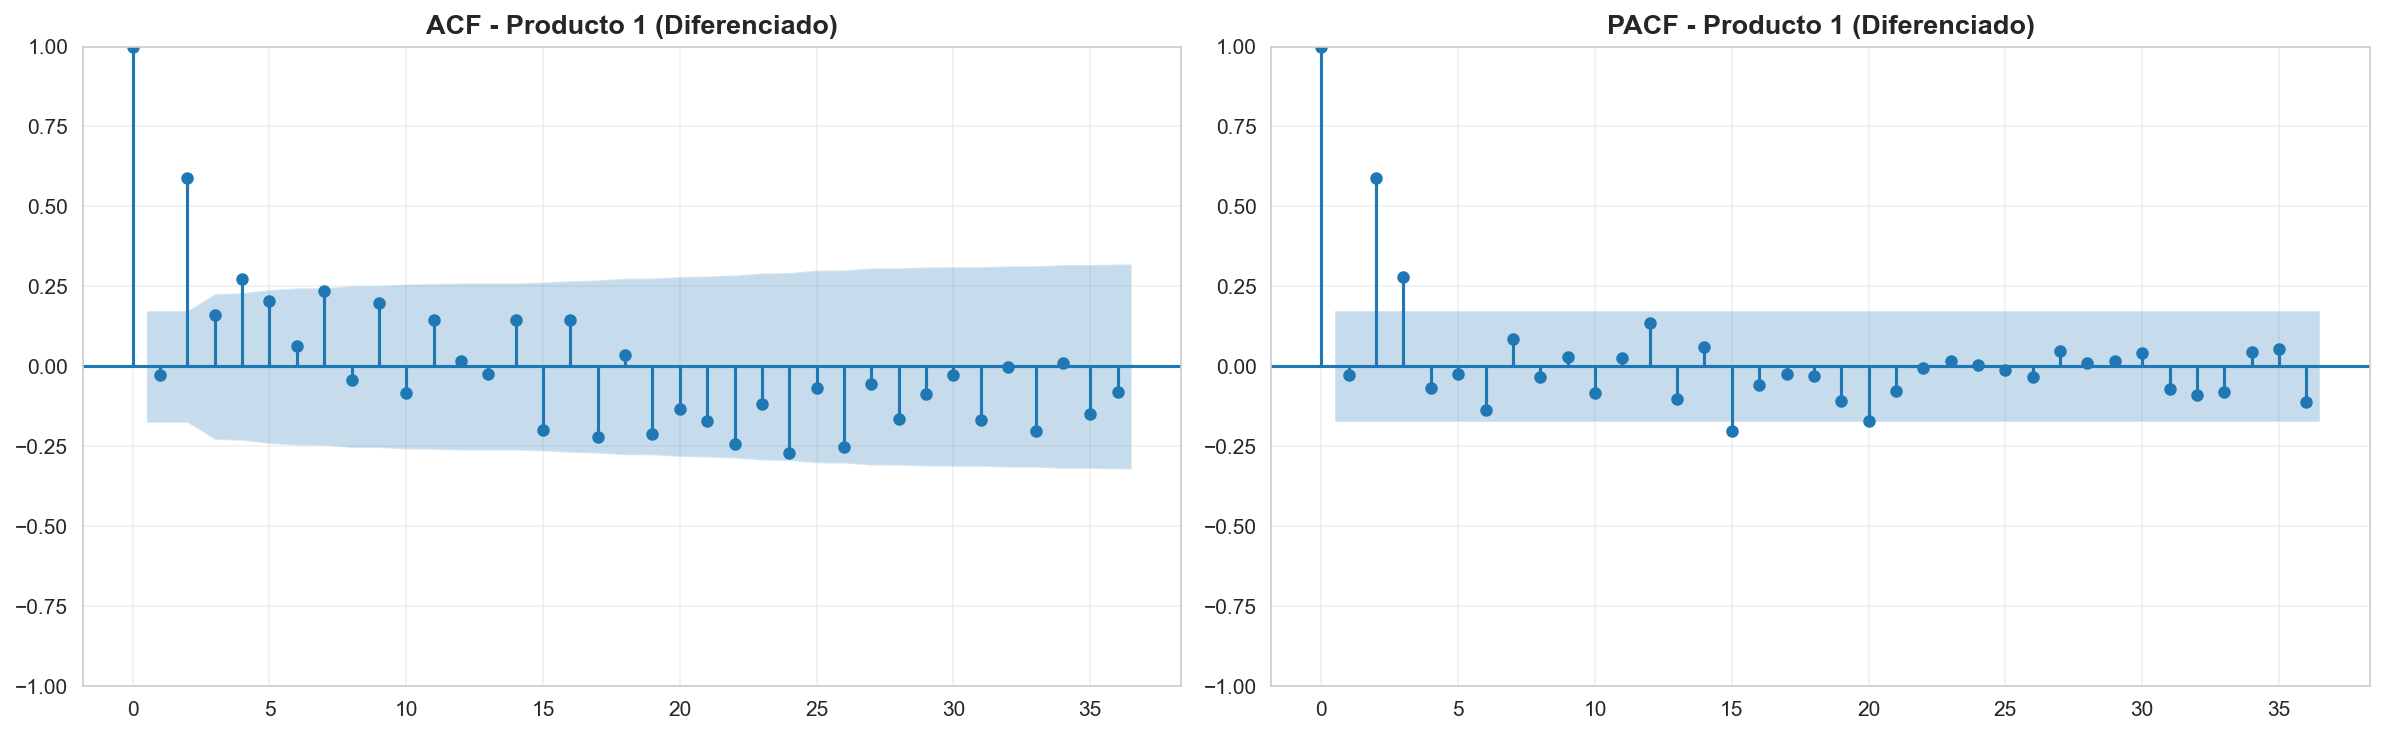

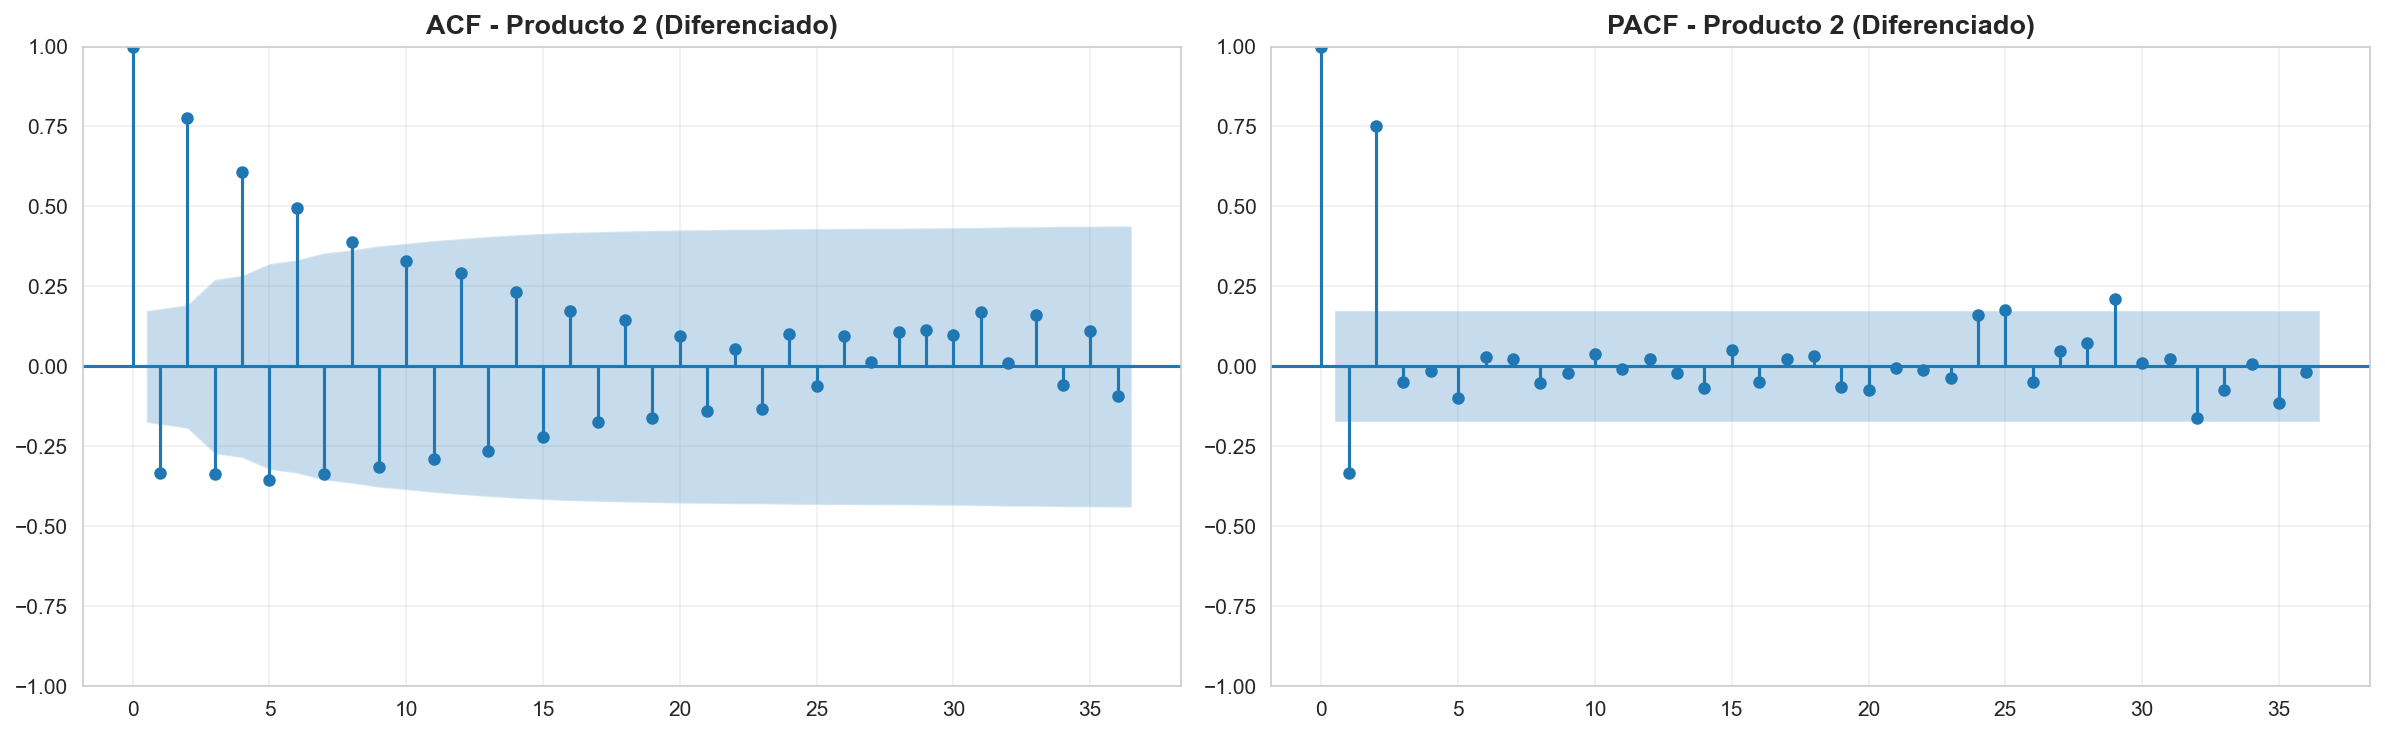

✓ Figuras 3a y 3b guardadas: ACF/PACF


In [9]:
# Análisis de Autocorrelación
df_diff = df.diff().dropna()

def plot_acf_pacf(series, series_name, filename):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))
    
    plot_acf(series, ax=ax1, lags=36, alpha=0.05)
    ax1.set_title(f'ACF - {series_name}', fontsize=13, fontweight='bold')
    ax1.grid(True, alpha=0.3)
    
    plot_pacf(series, ax=ax2, lags=36, alpha=0.05, method='ywm')
    ax2.set_title(f'PACF - {series_name}', fontsize=13, fontweight='bold')
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(f'outputs/{filename}', dpi=300, bbox_inches='tight')
    plt.show()

plot_acf_pacf(df_diff['producto1'], 'Producto 1 (Diferenciado)', 'fig3a_acf_pacf_p1.png')
plot_acf_pacf(df_diff['producto2'], 'Producto 2 (Diferenciado)', 'fig3b_acf_pacf_p2.png')

print("✓ Figuras 3a y 3b guardadas: ACF/PACF")

**Interpretación de ACF/PACF:**

Después de una diferenciación (d=1):
- **ACF**: Ambos productos muestran picos significativos en los primeros lags que decaen, sugiriendo componente **MA (Media Móvil)**
- **PACF**: También muestran picos significativos en primeros lags, sugiriendo componente **AR (Autorregresivo)**
- **Estacionalidad**: Se observan picos en lags 12, 24, 36 → confirma estacionalidad anual

Esto indica que modelos **ARIMA(p,1,q)** o **SARIMA(p,1,q)(P,D,Q)₁₂** serán apropiados.

## 3. PROTOCOLO DE EVALUACIÓN Y DIVISIÓN DE DATOS

### ⚠️ Decisión Crítica del Protocolo

**Protocolo Seleccionado: RECURSIVE WINDOW (Ventana Recursiva)**

**Justificación:**
1. **Simulación Realista**: Simula cómo una empresa realizaría pronósticos operacionalmente: predice el próximo mes, incorpora el valor real, y re-entrena
2. **Aprovechamiento de Información**: Usa toda la información histórica disponible progresivamente
3. **Evaluación Robusta**: Genera N pronósticos independientes (19 en este caso) en lugar de uno solo


**Por lo tanto vamos a realizar estos pasos**
1. Entrenar con datos históricos iniciales
2. Predecir siguiente periodo
3. **Agregar el valor real** al conjunto de entrenamiento
4. Re-entrenar el modelo
5. Repetir hasta cubrir todo el conjunto de test

In [10]:
# División de Datos
# 85% entrenamiento, 15% prueba (últimos 19 meses para validación robusta)
split_point = int(len(df) * 0.85)
train = df[:split_point]
test = df[split_point:]

print("="*60)
print("DIVISIÓN DE DATOS")
print("="*60)
print(f"Total de observaciones: {len(df)} meses")
print(f"\nConjunto de Entrenamiento:")
print(f"  - Tamaño: {len(train)} meses ({split_point/len(df)*100:.1f}%)")
print(f"  - Periodo: {train.index.min().strftime('%b %Y')} - {train.index.max().strftime('%b %Y')}")
print(f"\nConjunto de Prueba:")
print(f"  - Tamaño: {len(test)} meses ({len(test)/len(df)*100:.1f}%)")
print(f"  - Periodo: {test.index.min().strftime('%b %Y')} - {test.index.max().strftime('%b %Y')}")
print(f"\nHorizonte de pronóstico final: 1 mes (Enero 2025)")

# Separar por producto
train_p1, test_p1 = train['producto1'], test['producto1']
train_p2, test_p2 = train['producto2'], test['producto2']

DIVISIÓN DE DATOS
Total de observaciones: 127 meses

Conjunto de Entrenamiento:
  - Tamaño: 107 meses (84.3%)
  - Periodo: Jun 2014 - Apr 2023

Conjunto de Prueba:
  - Tamaño: 20 meses (15.7%)
  - Periodo: May 2023 - Dec 2024

Horizonte de pronóstico final: 1 mes (Enero 2025)


### 3.1 Funciones de Evaluación y Visualización

Definimos funciones robustas para:
1. Calcular métricas de evaluación
2. Implementar el protocolo de validación recursiva
3. Visualizar pronósticos y errores
4. Comparar múltiples modelos

In [11]:
# Funciones de Evaluación
def evaluate_metrics(actual, predicted):
    """Calcula métricas de evaluación estándar."""
    rmse = np.sqrt(mean_squared_error(actual, predicted))
    mae = mean_absolute_error(actual, predicted)
    # MAPE solo si no hay valores cercanos a 0
    if np.any(np.abs(actual) < 1):
        mape = np.nan
    else:
        mape = np.mean(np.abs((actual - predicted) / actual)) * 100
    return {'RMSE': rmse, 'MAE': mae, 'MAPE': mape}

def recursive_window_validation(train_series, test_series, model_fitter, model_name):
    """
    Implementa el PROTOCOLO RECURSIVE WINDOW
    
    Parámetros:
        train_series: Serie de entrenamiento inicial
        test_series: Serie de prueba
        model_fitter: Función que retorna un modelo ajustado dado un dataset
        model_name: Nombre del modelo para logging
    
    Retorna:
        predictions: Array con las predicciones
        metrics: Diccionario con métricas de evaluación
    """
    print(f"\n{'='*60}")
    print(f"PROTOCOLO: Recursive Window - {model_name}")
    print(f"{'='*60}")
    
    predictions = []
    actual_values = []
    errors = []
    
    # Dataset dinámico que crece en cada iteración
    current_train = train_series.copy()
    
    for i in range(len(test_series)):
        if (i+1) % 5 == 0 or i == 0:
            print(f"Iteración {i+1}/{len(test_series)}: Train size = {len(current_train)}")
        
        try:
            # 1. Entrenar modelo con datos actuales
            fitted_model = model_fitter(current_train)
            
            # 2. Predecir 1 paso adelante
            forecast = fitted_model.forecast(steps=1)
            pred_value = forecast.iloc[0] if hasattr(forecast, 'iloc') else forecast[0]
            
            # 3. Registrar predicción y valor real
            predictions.append(pred_value)
            actual_value = test_series.iloc[i]
            actual_values.append(actual_value)
            
            # 4. Calcular error
            error = actual_value - pred_value
            errors.append(error)
            
            # 5. CRÍTICO: Agregar valor real al training set para próxima iteración
            current_train = pd.concat([current_train, test_series.iloc[i:i+1]])
            
        except Exception as e:
            print(f"  ✗ Error en iteración {i+1}: {e}")
            predictions.append(np.nan)
            break
    
    # Filtrar NaNs
    valid_mask = ~np.isnan(predictions)
    valid_predictions = np.array(predictions)[valid_mask]
    valid_actuals = np.array(actual_values)[valid_mask]
    
    if len(valid_predictions) == 0:
        print(f"✗ Validación fallida para {model_name}")
        return None, None
    
    # Calcular métricas
    metrics = evaluate_metrics(valid_actuals, valid_predictions)
    
    print(f"\n{'='*60}")
    print(f"RESULTADOS - {model_name}")
    print(f"{'='*60}")
    print(f"  RMSE: {metrics['RMSE']:.2f}")
    print(f"  MAE:  {metrics['MAE']:.2f}")
    if not np.isnan(metrics['MAPE']):
        print(f"  MAPE: {metrics['MAPE']:.2f}%")
    print(f"  Predicciones válidas: {len(valid_predictions)}/{len(test_series)}")
    
    return valid_predictions, metrics

In [12]:
# Funciones de Visualización Avanzadas

def visualizar_pronostico_recursivo(train, test, predictions, model_name, producto_nombre, filename):
    """
    Visualización del pronóstico con protocolo recursivo
    Muestra datos históricos, valores reales y predicciones
    """
    fig, ax = plt.subplots(figsize=(14, 7))
    
    # Datos de entrenamiento
    ax.plot(train.index, train, label='Datos de Entrenamiento', 
            color='steelblue', linewidth=2, alpha=0.7)
    
    # Valores reales del test
    ax.plot(test.index, test, label='Valores Reales (Test)', 
            color='black', linewidth=2.5, marker='o', markersize=5)
    
    # Predicciones
    ax.plot(test.index[:len(predictions)], predictions, 
            label=f'Pronóstico {model_name}', 
            color='orangered', linewidth=2, marker='x', 
            markersize=7, linestyle='--')
    
    # Línea de separación
    ax.axvline(train.index[-1], color='red', linestyle='--', 
               linewidth=2, alpha=0.7, label='Inicio del Test')
    
    # Configuración
    ax.set_title(f'{producto_nombre}: Pronóstico Recursivo - {model_name}', 
                 fontsize=14, fontweight='bold')
    ax.set_xlabel('Periodo', fontsize=12)
    ax.set_ylabel('Ventas (unidades)', fontsize=12)
    ax.legend(loc='best', fontsize=10)
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(f'outputs/{filename}', dpi=300, bbox_inches='tight')
    plt.show()

def visualizar_analisis_error(test, predictions, producto_nombre, filename):
    """
    Análisis detallado de errores con dos subplots:
    1. Scatter plot (Real vs Predicho)
    2. Serie temporal de errores
    """
    errors = test.values[:len(predictions)] - predictions
    
    fig, axes = plt.subplots(2, 1, figsize=(14, 10))
    
    # Subplot 1: Scatter Real vs Predicho
    axes[0].scatter(test.values[:len(predictions)], predictions, 
                   alpha=0.6, s=80, color='steelblue', edgecolors='black')
    
    # Línea de ajuste perfecto
    min_val = min(test.values[:len(predictions)].min(), predictions.min())
    max_val = max(test.values[:len(predictions)].max(), predictions.max())
    axes[0].plot([min_val, max_val], [min_val, max_val], 
                'r--', linewidth=2, label='Predicción Perfecta')
    
    axes[0].set_xlabel('Valores Reales', fontsize=12)
    axes[0].set_ylabel('Valores Predichos', fontsize=12)
    axes[0].set_title(f'{producto_nombre}: Real vs Predicho', 
                     fontsize=13, fontweight='bold')
    axes[0].legend(loc='best')
    axes[0].grid(True, alpha=0.3)
    
    # Subplot 2: Serie de Errores
    axes[1].plot(range(len(errors)), errors, marker='o', 
                linestyle='-', color='coral', linewidth=2, markersize=5)
    axes[1].axhline(y=0, color='black', linestyle='--', linewidth=1.5)
    axes[1].fill_between(range(len(errors)), errors, 0, 
                        alpha=0.3, color='coral')
    
    axes[1].set_xlabel('Periodo de Test', fontsize=12)
    axes[1].set_ylabel('Error (Real - Predicho)', fontsize=12)
    axes[1].set_title(f'{producto_nombre}: Errores de Predicción', 
                     fontsize=13, fontweight='bold')
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(f'outputs/{filename}', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Estadísticas de error
    print(f"\n{'='*50}")
    print(f"ANÁLISIS DE ERROR - {producto_nombre}")
    print(f"{'='*50}")
    print(f"Error Medio: {errors.mean():.4f}")
    print(f"Error Absoluto Medio: {np.abs(errors).mean():.4f}")
    print(f"Error Cuadrático Medio: {np.sqrt((errors**2).mean()):.4f}")
    print(f"Error Máximo: {errors.max():.4f}")
    print(f"Error Mínimo: {errors.min():.4f}")

def visualizar_comparacion_modelos(test, resultados_modelos, producto_nombre, filename):
    """
    Comparación visual del desempeño de múltiples modelos
    """
    fig, axes = plt.subplots(2, 1, figsize=(14, 10))
    
    # Subplot 1: Series de pronósticos
    axes[0].plot(test.index, test, label='Valores Reales', 
                 color='black', linewidth=3, marker='o', markersize=5, zorder=10)
    
    colores = ['steelblue', 'coral', 'green', 'purple', 'orange', 'brown']
    for i, (nombre_modelo, predicciones) in enumerate(resultados_modelos.items()):
        axes[0].plot(test.index[:len(predicciones)], predicciones, 
                     label=nombre_modelo, linewidth=2, marker='s', markersize=3,
                     color=colores[i % len(colores)], alpha=0.7)
    
    axes[0].set_title(f'{producto_nombre}: Comparación de Pronósticos', 
                      fontsize=13, fontweight='bold')
    axes[0].set_xlabel('Periodo', fontsize=11)
    axes[0].set_ylabel('Ventas (unidades)', fontsize=11)
    axes[0].legend(loc='best', fontsize=9)
    axes[0].grid(True, alpha=0.3)
    
    # Subplot 2: Métricas comparativas (barras)
    modelos_nombres = list(resultados_modelos.keys())
    rmse_values = []
    mae_values = []
    
    for nombre, predicciones in resultados_modelos.items():
        test_vals = test.values[:len(predicciones)]
        rmse = np.sqrt(mean_squared_error(test_vals, predicciones))
        mae = mean_absolute_error(test_vals, predicciones)
        rmse_values.append(rmse)
        mae_values.append(mae)
    
    x = np.arange(len(modelos_nombres))
    width = 0.35
    
    axes[1].bar(x - width/2, rmse_values, width, 
                label='RMSE', color='steelblue', alpha=0.8)
    axes[1].bar(x + width/2, mae_values, width, 
                label='MAE', color='coral', alpha=0.8)
    
    # Marcar el mejor modelo
    mejor_modelo_idx = np.argmin(rmse_values)
    axes[1].axvline(x=mejor_modelo_idx, color='green', 
                    linestyle='--', linewidth=2, alpha=0.5,
                    label='Mejor Modelo')
    
    axes[1].set_title(f'{producto_nombre}: Métricas de Error por Modelo', 
                      fontsize=13, fontweight='bold')
    axes[1].set_xlabel('Modelo', fontsize=11)
    axes[1].set_ylabel('Error', fontsize=11)
    axes[1].set_xticks(x)
    axes[1].set_xticklabels(modelos_nombres, rotation=15, ha='right')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.savefig(f'outputs/{filename}', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Tabla de métricas
    print(f"\n{'='*60}")
    print(f"TABLA DE MÉTRICAS - {producto_nombre}")
    print(f"{'='*60}")
    df_metrics = pd.DataFrame({
        'Modelo': modelos_nombres,
        'RMSE': rmse_values,
        'MAE': mae_values
    }).sort_values('RMSE')
    print(df_metrics.to_string(index=False))
    print(f"\n✓ Mejor modelo: {df_metrics.iloc[0]['Modelo']}")

print("✓ Funciones de evaluación y visualización definidas")

✓ Funciones de evaluación y visualización definidas


## 4. MODELADO Y SELECCIÓN - PRODUCTO 1

### 4.1 Modelos Baseline

Comenzamos con modelos simples para establecer una línea base de desempeño.

In [13]:
# Inicialización de estructuras de datos para almacenar resultados
results = {'p1': {}, 'p2': {}}
predictions_p1 = {}

print("="*60)
print("INICIALIZACIÓN DE EVALUACIÓN DE MODELOS")
print("="*60)
print("✓ Estructuras de datos creadas")
print("✓ Listo para evaluar modelos Producto 1")

INICIALIZACIÓN DE EVALUACIÓN DE MODELOS
✓ Estructuras de datos creadas
✓ Listo para evaluar modelos Producto 1


In [14]:
# ===== MODELOS BASELINE - PRODUCTO 1 =====

print("\n" + "="*60)
print("EVALUANDO MODELOS BASELINE - PRODUCTO 1")
print("="*60)

# Media Móvil con k = [3, 5, 7] (según curso)
k_values = [3, 5, 7]
best_k, best_rmse = -1, float('inf')

for k in k_values:
    ma_forecast = np.full(len(test_p1), train_p1.tail(k).mean())
    rmse = np.sqrt(mean_squared_error(test_p1, ma_forecast))
    print(f"  MA(k={k}): RMSE = {rmse:.2f}")
    if rmse < best_rmse:
        best_rmse = rmse
        best_k = k

ma_forecast_best = np.full(len(test_p1), train_p1.tail(best_k).mean())
results['p1'][f'MA(k={best_k})'] = evaluate_metrics(test_p1, ma_forecast_best)
predictions_p1[f'MA(k={best_k})'] = ma_forecast_best

print(f"\n✓ Mejor Media Móvil: k={best_k} con RMSE={best_rmse:.2f}")


EVALUANDO MODELOS BASELINE - PRODUCTO 1
  MA(k=3): RMSE = 104.30
  MA(k=5): RMSE = 110.87
  MA(k=7): RMSE = 118.80

✓ Mejor Media Móvil: k=3 con RMSE=104.30


### 4.2 Familia de Suavizamiento Exponencial (ETS)

Evaluamos diferentes variantes de suavizamiento exponencial.

In [15]:
# ===== FAMILIA ETS - PRODUCTO 1 =====

print("\n" + "="*60)
print("EVALUANDO FAMILIA ETS - PRODUCTO 1")
print("="*60)

# SES (Simple Exponential Smoothing)
print("\nEvaluando SES...")
def ses_fitter(data):
    return SimpleExpSmoothing(data, initialization_method="estimated").fit()

preds_ses, metrics_ses = recursive_window_validation(train_p1, test_p1, ses_fitter, 'SES')
if metrics_ses:
    results['p1']['SES'] = metrics_ses
    predictions_p1['SES'] = preds_ses

# Holt's Linear Trend
print("\nEvaluando Holt...")
def holt_fitter(data):
    return Holt(data, initialization_method="estimated").fit()

preds_holt, metrics_holt = recursive_window_validation(train_p1, test_p1, holt_fitter, 'Holt')
if metrics_holt:
    results['p1']['Holt'] = metrics_holt
    predictions_p1['Holt'] = preds_holt

# Holt-Winters (Tendencia + Estacionalidad)
print("\nEvaluando Holt-Winters...")
def holt_winters_fitter(data):
    return ExponentialSmoothing(data, seasonal_periods=12, trend='add', 
                                seasonal='add', initialization_method="estimated").fit()

preds_hw, metrics_hw = recursive_window_validation(train_p1, test_p1, holt_winters_fitter, 'Holt-Winters')
if metrics_hw:
    results['p1']['Holt-Winters'] = metrics_hw
    predictions_p1['Holt-Winters'] = preds_hw

print("\n✓ Familia ETS evaluada")


EVALUANDO FAMILIA ETS - PRODUCTO 1

Evaluando SES...

PROTOCOLO: Recursive Window - SES
Iteración 1/20: Train size = 107
Iteración 5/20: Train size = 111
Iteración 10/20: Train size = 116
Iteración 15/20: Train size = 121
Iteración 20/20: Train size = 126

RESULTADOS - SES
  RMSE: 12.03
  MAE:  9.51
  MAPE: 4.84%
  Predicciones válidas: 20/20

Evaluando Holt...

PROTOCOLO: Recursive Window - Holt
Iteración 1/20: Train size = 107
Iteración 5/20: Train size = 111
Iteración 10/20: Train size = 116
Iteración 15/20: Train size = 121
Iteración 20/20: Train size = 126

RESULTADOS - Holt
  RMSE: 9.06
  MAE:  7.30
  MAPE: 3.74%
  Predicciones válidas: 20/20

Evaluando Holt-Winters...

PROTOCOLO: Recursive Window - Holt-Winters
Iteración 1/20: Train size = 107
Iteración 5/20: Train size = 111
Iteración 10/20: Train size = 116
Iteración 15/20: Train size = 121
Iteración 20/20: Train size = 126

RESULTADOS - Holt-Winters
  RMSE: 9.67
  MAE:  8.04
  MAPE: 4.14%
  Predicciones válidas: 20/20

✓ Fam

### 4.3 Familia ARIMA

Utilizamos ARIMA con órdenes seleccionados basados en análisis ACF/PACF.

In [16]:
# ===== FAMILIA ARIMA - PRODUCTO 1 =====

# Probar varios órdenes ARIMA basados en análisis ACF/PACF
arima_orders = [
    (1, 1, 1),  # ARIMA básico
    (2, 1, 2),  # Más componentes
    (1, 1, 2),  # Variante MA
]

for order in arima_orders:
    print(f"\nEvaluando ARIMA{order}...")
    
    def arima_fitter(data):
        return ARIMA(data, order=order).fit()
    
    try:
        preds_arima, metrics_arima = recursive_window_validation(
            train_p1, test_p1, arima_fitter, f'ARIMA{order}')
        
        if metrics_arima:
            results['p1'][f'ARIMA{order}'] = metrics_arima
            predictions_p1[f'ARIMA{order}'] = preds_arima
    except Exception as e:
        print(f"  ✗ Error con ARIMA{order}: {e}")


Evaluando ARIMA(1, 1, 1)...

PROTOCOLO: Recursive Window - ARIMA(1, 1, 1)
Iteración 1/20: Train size = 107
Iteración 5/20: Train size = 111
Iteración 10/20: Train size = 116
Iteración 15/20: Train size = 121
Iteración 20/20: Train size = 126

RESULTADOS - ARIMA(1, 1, 1)
  RMSE: 10.56
  MAE:  9.05
  MAPE: 4.60%
  Predicciones válidas: 20/20

Evaluando ARIMA(2, 1, 2)...

PROTOCOLO: Recursive Window - ARIMA(2, 1, 2)
Iteración 1/20: Train size = 107
Iteración 5/20: Train size = 111
Iteración 10/20: Train size = 116
Iteración 15/20: Train size = 121
Iteración 20/20: Train size = 126

RESULTADOS - ARIMA(2, 1, 2)
  RMSE: 7.84
  MAE:  6.13
  MAPE: 3.22%
  Predicciones válidas: 20/20

Evaluando ARIMA(1, 1, 2)...

PROTOCOLO: Recursive Window - ARIMA(1, 1, 2)
Iteración 1/20: Train size = 107
Iteración 5/20: Train size = 111
Iteración 10/20: Train size = 116
Iteración 15/20: Train size = 121
Iteración 20/20: Train size = 126

RESULTADOS - ARIMA(1, 1, 2)
  RMSE: 9.31
  MAE:  8.05
  MAPE: 4.33%
  P

### 4.4 Optimización Bayesiana con Optuna

**Objetivo:** Encontrar automáticamente la mejor configuración de hiperparámetros para el modelo ETS.

Con Optuna exploraremos diferentes combinaciones de:
- Error: aditivo vs multiplicativo
- Tendencia: aditiva vs multiplicativa
- Amortiguación: con/sin damped trend
- Estacionalidad: aditiva, multiplicativa o ninguna

In [17]:
# ===== OPTIMIZACIÓN BAYESIANA CON OPTUNA - PRODUCTO 1 =====

def objective_ets_p1(trial):
    """Función objetivo para Optuna - minimizar RMSE"""
    # Definir espacio de búsqueda
    error = trial.suggest_categorical('error', ['add', 'mul'])
    trend = trial.suggest_categorical('trend', ['add', 'mul'])
    damped = trial.suggest_categorical('damped_trend', [True, False])
    seasonal = trial.suggest_categorical('seasonal', ['add', 'mul', None])
    seasonal_periods = 12 if seasonal else None
    
    try:
        # Ajustar modelo ETS
        model = ETSModel(
            train_p1,
            error=error,
            trend=trend,
            damped_trend=damped,
            seasonal=seasonal,
            seasonal_periods=seasonal_periods,
            initialization_method='estimated'
        ).fit(disp=False)
        
        # Evaluar en test set (fixed window para rapidez)
        forecast = model.forecast(len(test_p1))
        rmse = np.sqrt(mean_squared_error(test_p1, forecast))
        return rmse
        
    except Exception:
        # Combinación inválida → penalizar con valor alto
        return float('inf')

print("\n" + "="*60)
print("OPTIMIZACIÓN BAYESIANA - ETS PRODUCTO 1")
print("="*60)
print("Buscando mejor configuración de hiperparámetros...")
print("(Esto puede tomar varios minutos)")

# Crear estudio de Optuna
study_p1 = optuna.create_study(direction='minimize', study_name='ETS_P1')
optuna.logging.set_verbosity(optuna.logging.WARNING)

# Optimizar (100 trials)
study_p1.optimize(objective_ets_p1, n_trials=100, show_progress_bar=True)

optuna.logging.set_verbosity(optuna.logging.INFO)

# Resultados
best_params_p1 = study_p1.best_params
print(f"\n{'='*60}")
print("RESULTADOS DE OPTIMIZACIÓN - PRODUCTO 1")
print(f"{'='*60}")
print(f"Mejores parámetros encontrados:")
for param, value in best_params_p1.items():
    print(f"  {param:20s}: {value}")
print(f"\nMejor RMSE (Fixed Window): {study_p1.best_value:.2f}")

# Evaluar el mejor modelo con RECURSIVE WINDOW
print(f"\n{'='*60}")
print("EVALUANDO MEJOR MODELO CON RECURSIVE WINDOW")
print(f"{'='*60}")

def ets_optuna_fitter(data):
    seasonal_periods = 12 if best_params_p1.get('seasonal') else None
    return ETSModel(data, **best_params_p1, seasonal_periods=seasonal_periods, 
                   initialization_method='estimated').fit(disp=False)

preds_ets_optuna, metrics_ets_optuna = recursive_window_validation(
    train_p1, test_p1, ets_optuna_fitter, 'ETS Optuna')

if metrics_ets_optuna:
    results['p1']['ETS Optuna'] = metrics_ets_optuna
    predictions_p1['ETS Optuna'] = preds_ets_optuna

print("\n✓ Optimización completada para Producto 1")

[I 2025-11-27 00:16:43,564] A new study created in memory with name: ETS_P1



OPTIMIZACIÓN BAYESIANA - ETS PRODUCTO 1
Buscando mejor configuración de hiperparámetros...
(Esto puede tomar varios minutos)


Best trial: 10. Best value: 19.5334: 100%|██████████| 100/100 [00:11<00:00,  8.53it/s]



RESULTADOS DE OPTIMIZACIÓN - PRODUCTO 1
Mejores parámetros encontrados:
  error               : mul
  trend               : add
  damped_trend        : False
  seasonal            : add

Mejor RMSE (Fixed Window): 19.53

EVALUANDO MEJOR MODELO CON RECURSIVE WINDOW

PROTOCOLO: Recursive Window - ETS Optuna
Iteración 1/20: Train size = 107
Iteración 5/20: Train size = 111
Iteración 10/20: Train size = 116
Iteración 15/20: Train size = 121
Iteración 20/20: Train size = 126

RESULTADOS - ETS Optuna
  RMSE: 9.57
  MAE:  7.81
  MAPE: 4.00%
  Predicciones válidas: 20/20

✓ Optimización completada para Producto 1


### 4.5 Comparación y Selección del Mejor Modelo - Producto 1

**Figura 4**: Comparación de todos los modelos evaluados


TABLA COMPARATIVA DE MODELOS - PRODUCTO 1
                  RMSE    MAE   MAPE
ARIMA(2, 1, 2)    7.84   6.13   3.22
Holt              9.06   7.30   3.74
ARIMA(1, 1, 2)    9.31   8.05   4.33
ETS Optuna        9.57   7.81   4.00
Holt-Winters      9.67   8.04   4.14
ARIMA(1, 1, 1)   10.56   9.05   4.60
SES              12.03   9.51   4.84
MA(k=3)         104.30  95.18  55.86

✓ MEJOR MODELO: ARIMA(2, 1, 2)
  RMSE: 7.84
  MAE:  6.13


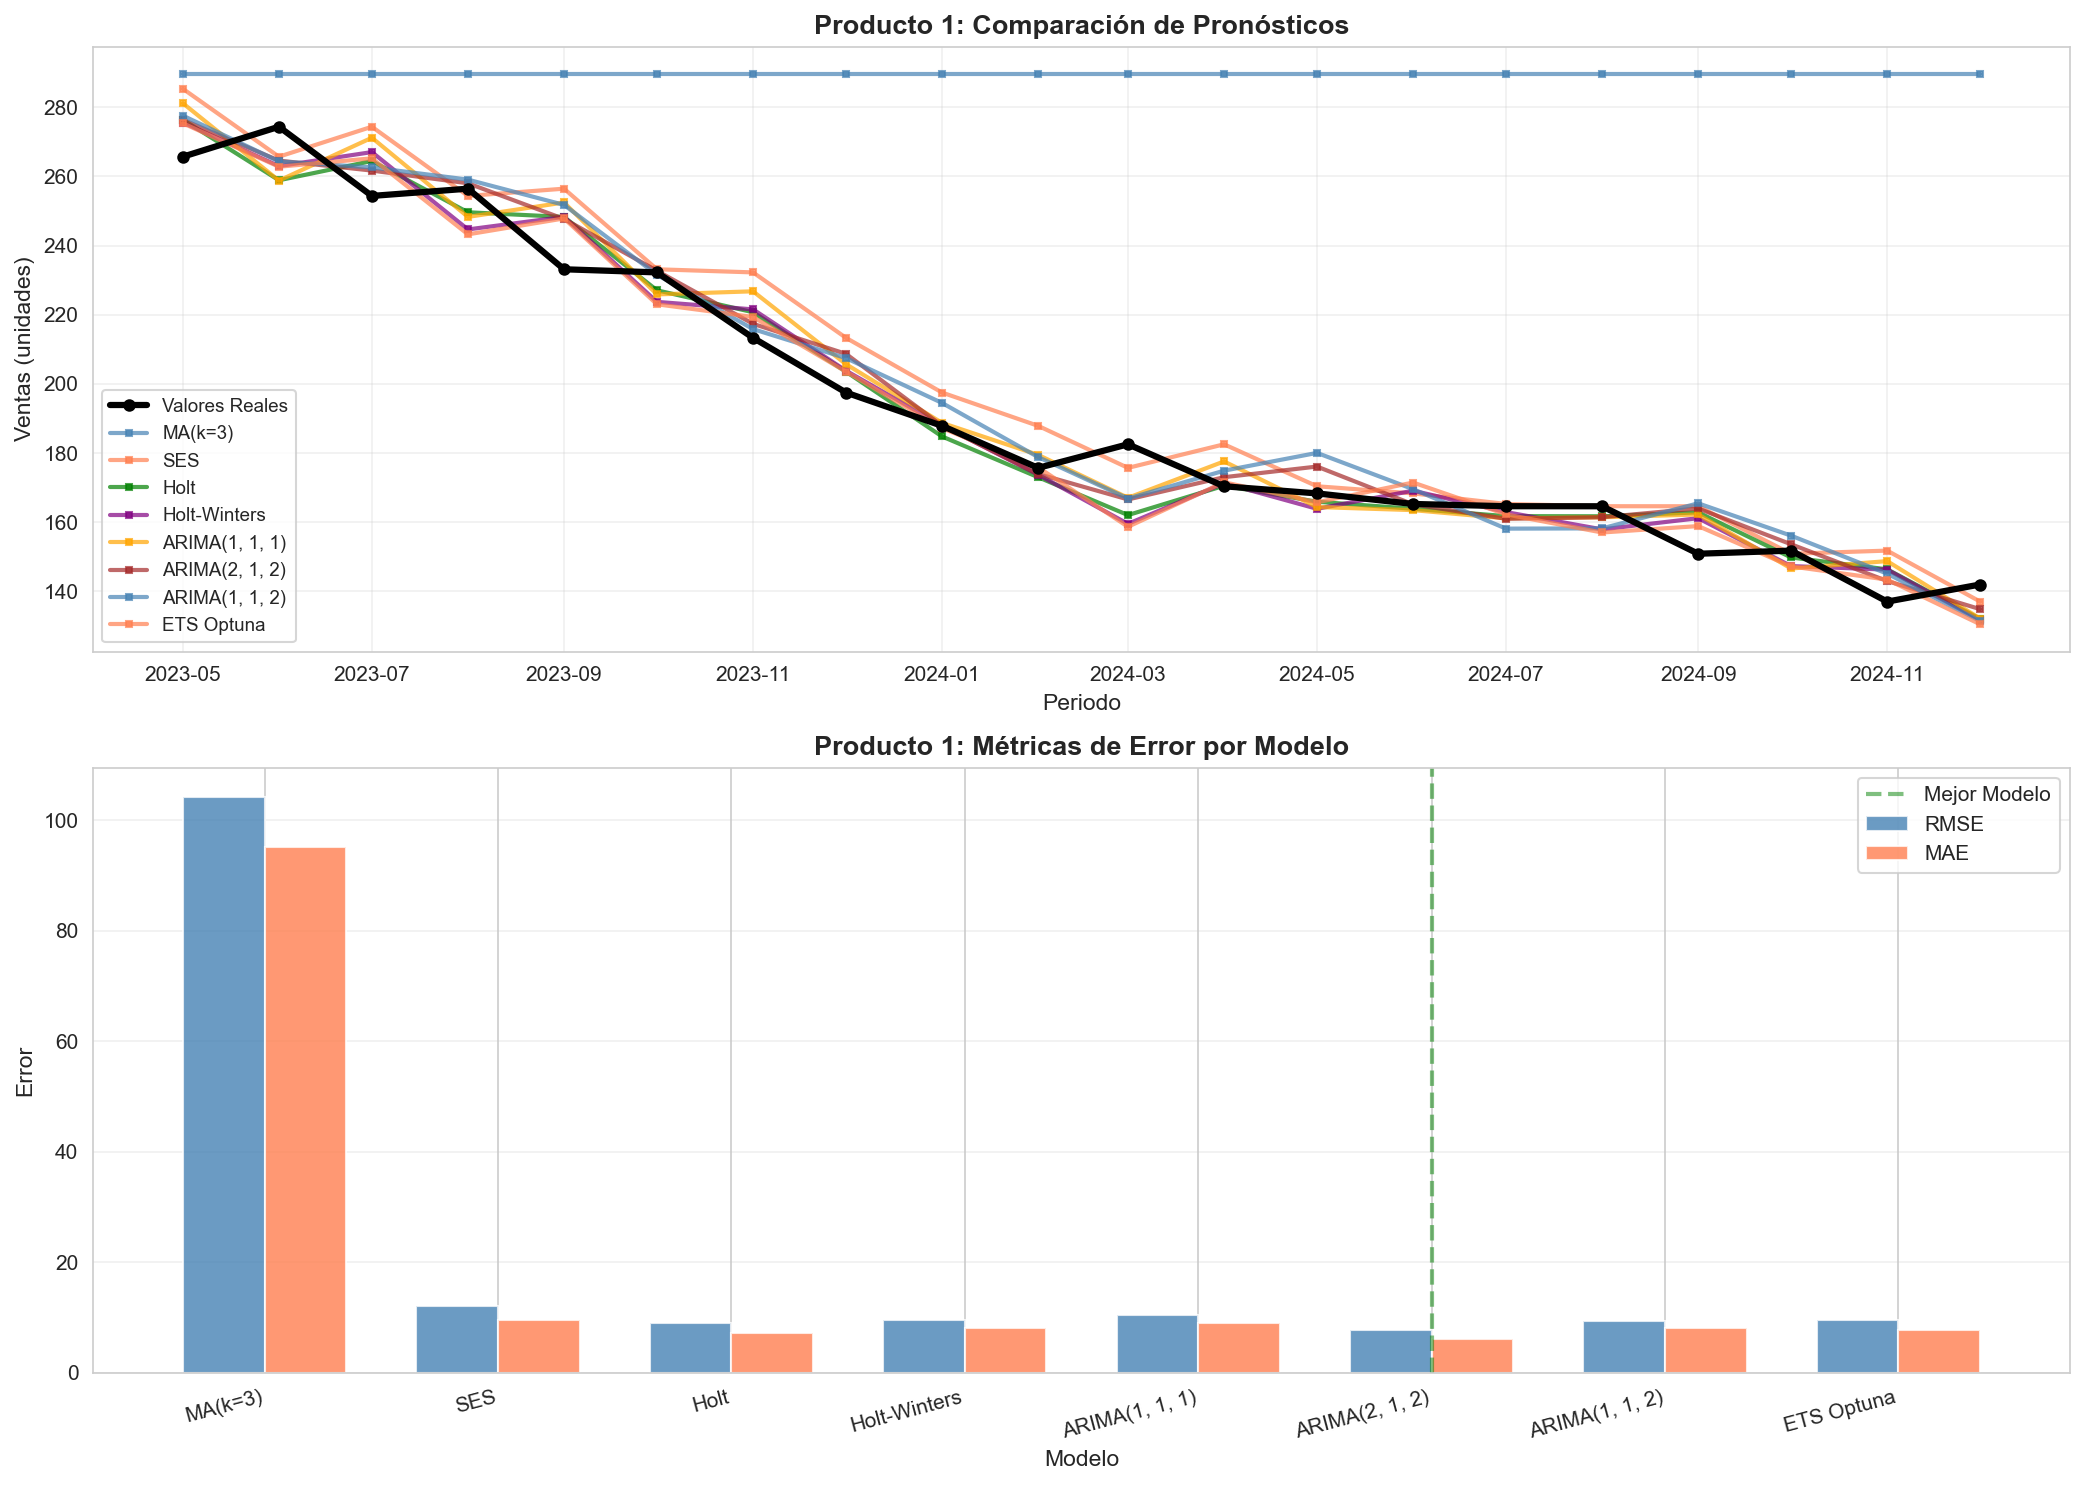


TABLA DE MÉTRICAS - Producto 1
        Modelo       RMSE       MAE
ARIMA(2, 1, 2)   7.837774  6.133279
          Holt   9.060923  7.299457
ARIMA(1, 1, 2)   9.314926  8.045283
    ETS Optuna   9.565316  7.814491
  Holt-Winters   9.666872  8.044028
ARIMA(1, 1, 1)  10.556426  9.053958
           SES  12.034099  9.508841
       MA(k=3) 104.298112 95.183401

✓ Mejor modelo: ARIMA(2, 1, 2)

✓ Figura 4 guardada: fig4_comparacion_p1.png


In [18]:
# ===== COMPARACIÓN DE MODELOS - PRODUCTO 1 =====

# Tabla comparativa
df_results_p1 = pd.DataFrame(results['p1']).T.sort_values(by='RMSE')
print("\n" + "="*60)
print("TABLA COMPARATIVA DE MODELOS - PRODUCTO 1")
print("="*60)
print(df_results_p1.round(2))

# Identificar mejor modelo
mejor_modelo_p1 = df_results_p1.index[0]
print(f"\n✓ MEJOR MODELO: {mejor_modelo_p1}")
print(f"  RMSE: {df_results_p1.iloc[0]['RMSE']:.2f}")
print(f"  MAE:  {df_results_p1.iloc[0]['MAE']:.2f}")

# Visualización comparativa
visualizar_comparacion_modelos(test_p1, predictions_p1, 'Producto 1', 'fig4_comparacion_p1.png')

print("\n✓ Figura 4 guardada: fig4_comparacion_p1.png")

### 4.6 Diagnóstico de Residuales del Mejor Modelo

**Figura 5**: Análisis exhaustivo de residuales para validar calidad del modelo

Un buen modelo debe tener residuales que se comporten como ruido blanco:
- Media cercana a 0
- Varianza constante
- Sin autocorrelación
- Distribución aproximadamente normal

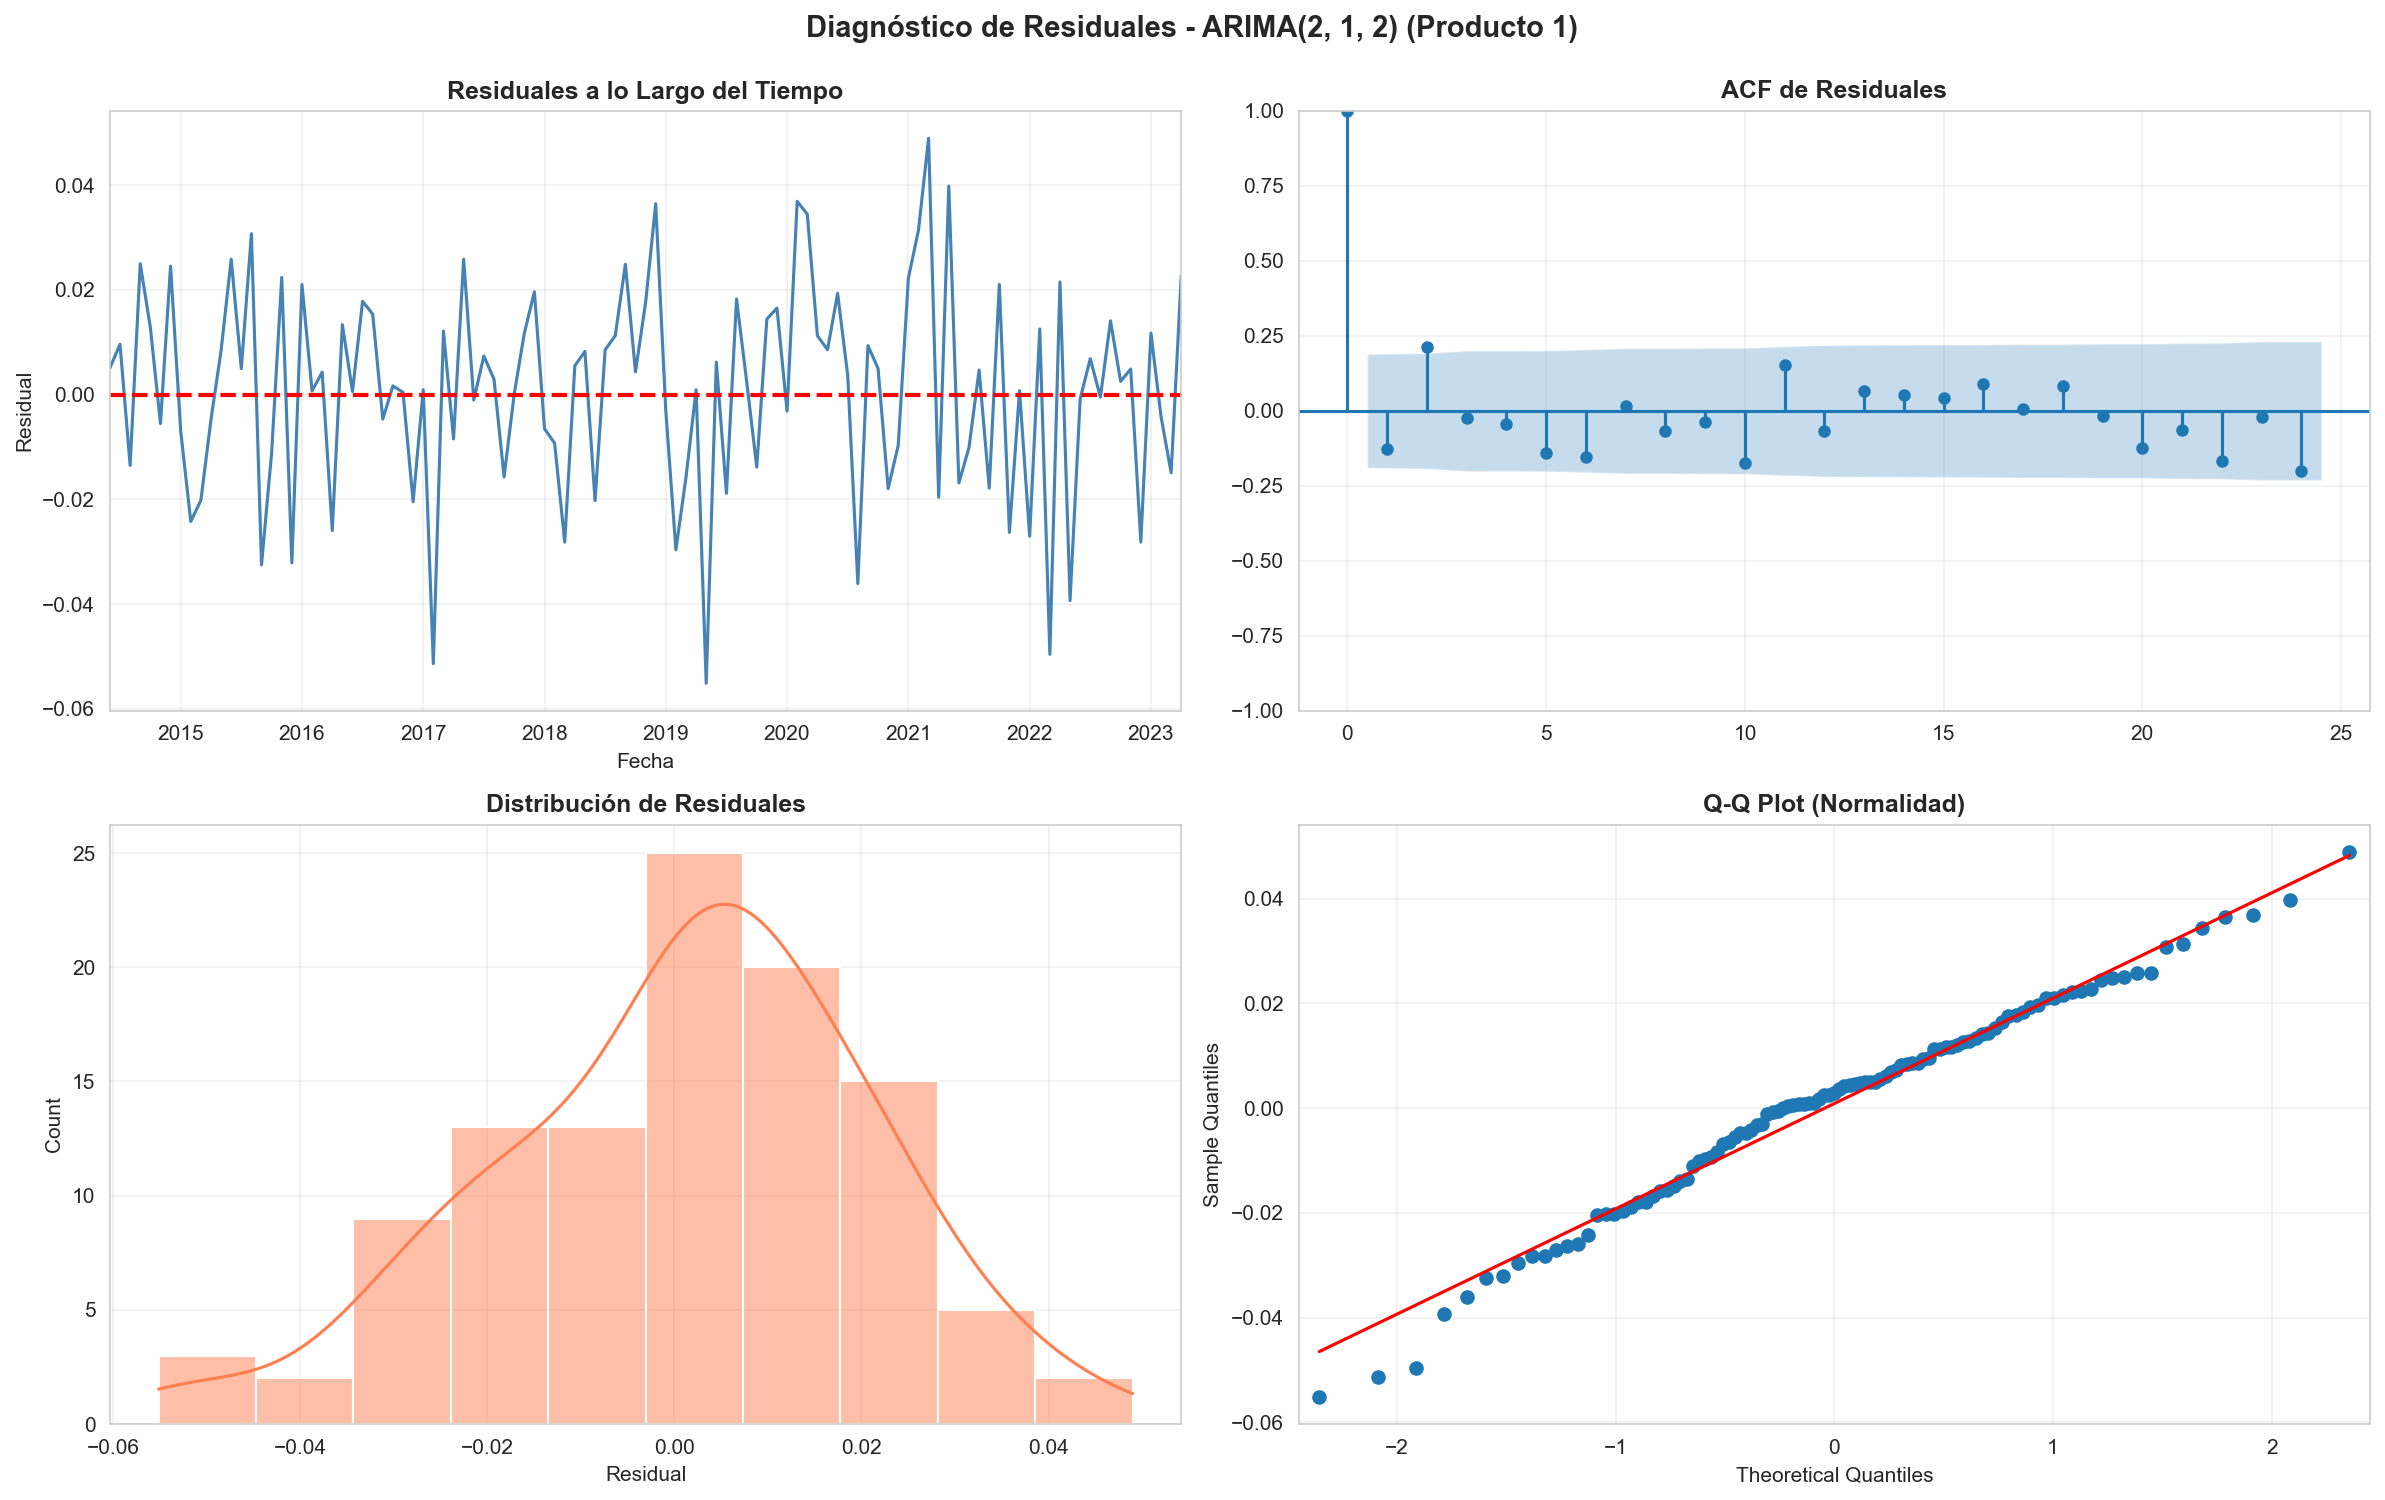


PRUEBA DE LJUNG-BOX (Autocorrelación de Residuales)
      lb_stat  lb_pvalue
24  35.205544   0.065411

✓ Conclusión: No hay evidencia de autocorrelación (p=0.0654 > 0.05)
  Los residuales se comportan como ruido blanco → Modelo adecuado

✓ Figura 5 guardada: fig5_diagnostico_residuales_p1.png


In [19]:
# ===== DIAGNÓSTICO DE RESIDUALES - PRODUCTO 1 =====

# Entrenar mejor modelo con todo el training set
best_model_p1_fit = ETSModel(
    train_p1, 
    **best_params_p1, 
    seasonal_periods=12 if best_params_p1.get('seasonal') else None,
    initialization_method='estimated'
).fit(disp=False)

residuals_p1 = best_model_p1_fit.resid

# Visualización de diagnóstico
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# 1. Residuales vs Tiempo
residuals_p1.plot(ax=axes[0, 0], color='steelblue', linewidth=1.5)
axes[0, 0].axhline(0, color='red', linestyle='--', linewidth=2)
axes[0, 0].set_title('Residuales a lo Largo del Tiempo', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Fecha')
axes[0, 0].set_ylabel('Residual')
axes[0, 0].grid(True, alpha=0.3)

# 2. ACF de Residuales
plot_acf(residuals_p1, ax=axes[0, 1], lags=24, alpha=0.05)
axes[0, 1].set_title('ACF de Residuales', fontsize=12, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)

# 3. Histograma
sns.histplot(residuals_p1, kde=True, ax=axes[1, 0], color='coral')
axes[1, 0].set_title('Distribución de Residuales', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Residual')
axes[1, 0].grid(True, alpha=0.3)

# 4. Q-Q Plot
sm.qqplot(residuals_p1, line='s', ax=axes[1, 1])
axes[1, 1].set_title('Q-Q Plot (Normalidad)', fontsize=12, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3)

plt.suptitle(f'Diagnóstico de Residuales - {mejor_modelo_p1} (Producto 1)', 
             fontsize=14, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig('outputs/fig5_diagnostico_residuales_p1.png', dpi=300, bbox_inches='tight')
plt.show()

# Prueba de Ljung-Box para autocorrelación
lb_test = acorr_ljungbox(residuals_p1, lags=[24], return_df=True)
print("\n" + "="*60)
print("PRUEBA DE LJUNG-BOX (Autocorrelación de Residuales)")
print("="*60)
print(lb_test)

if lb_test['lb_pvalue'].iloc[0] > 0.05:
    print(f"\n✓ Conclusión: No hay evidencia de autocorrelación (p={lb_test['lb_pvalue'].iloc[0]:.4f} > 0.05)")
    print("  Los residuales se comportan como ruido blanco → Modelo adecuado")
else:
    print(f"\n✗ Conclusión: Hay evidencia de autocorrelación (p={lb_test['lb_pvalue'].iloc[0]:.4f} ≤ 0.05)")
    print("  Los residuales tienen estructura → Modelo podría mejorarse")

print("\n✓ Figura 5 guardada: fig5_diagnostico_residuales_p1.png")

### 4.7 Visualizaciones Finales - Producto 1

**Figuras 6-7**: Pronósticos y análisis de errores del mejor modelo

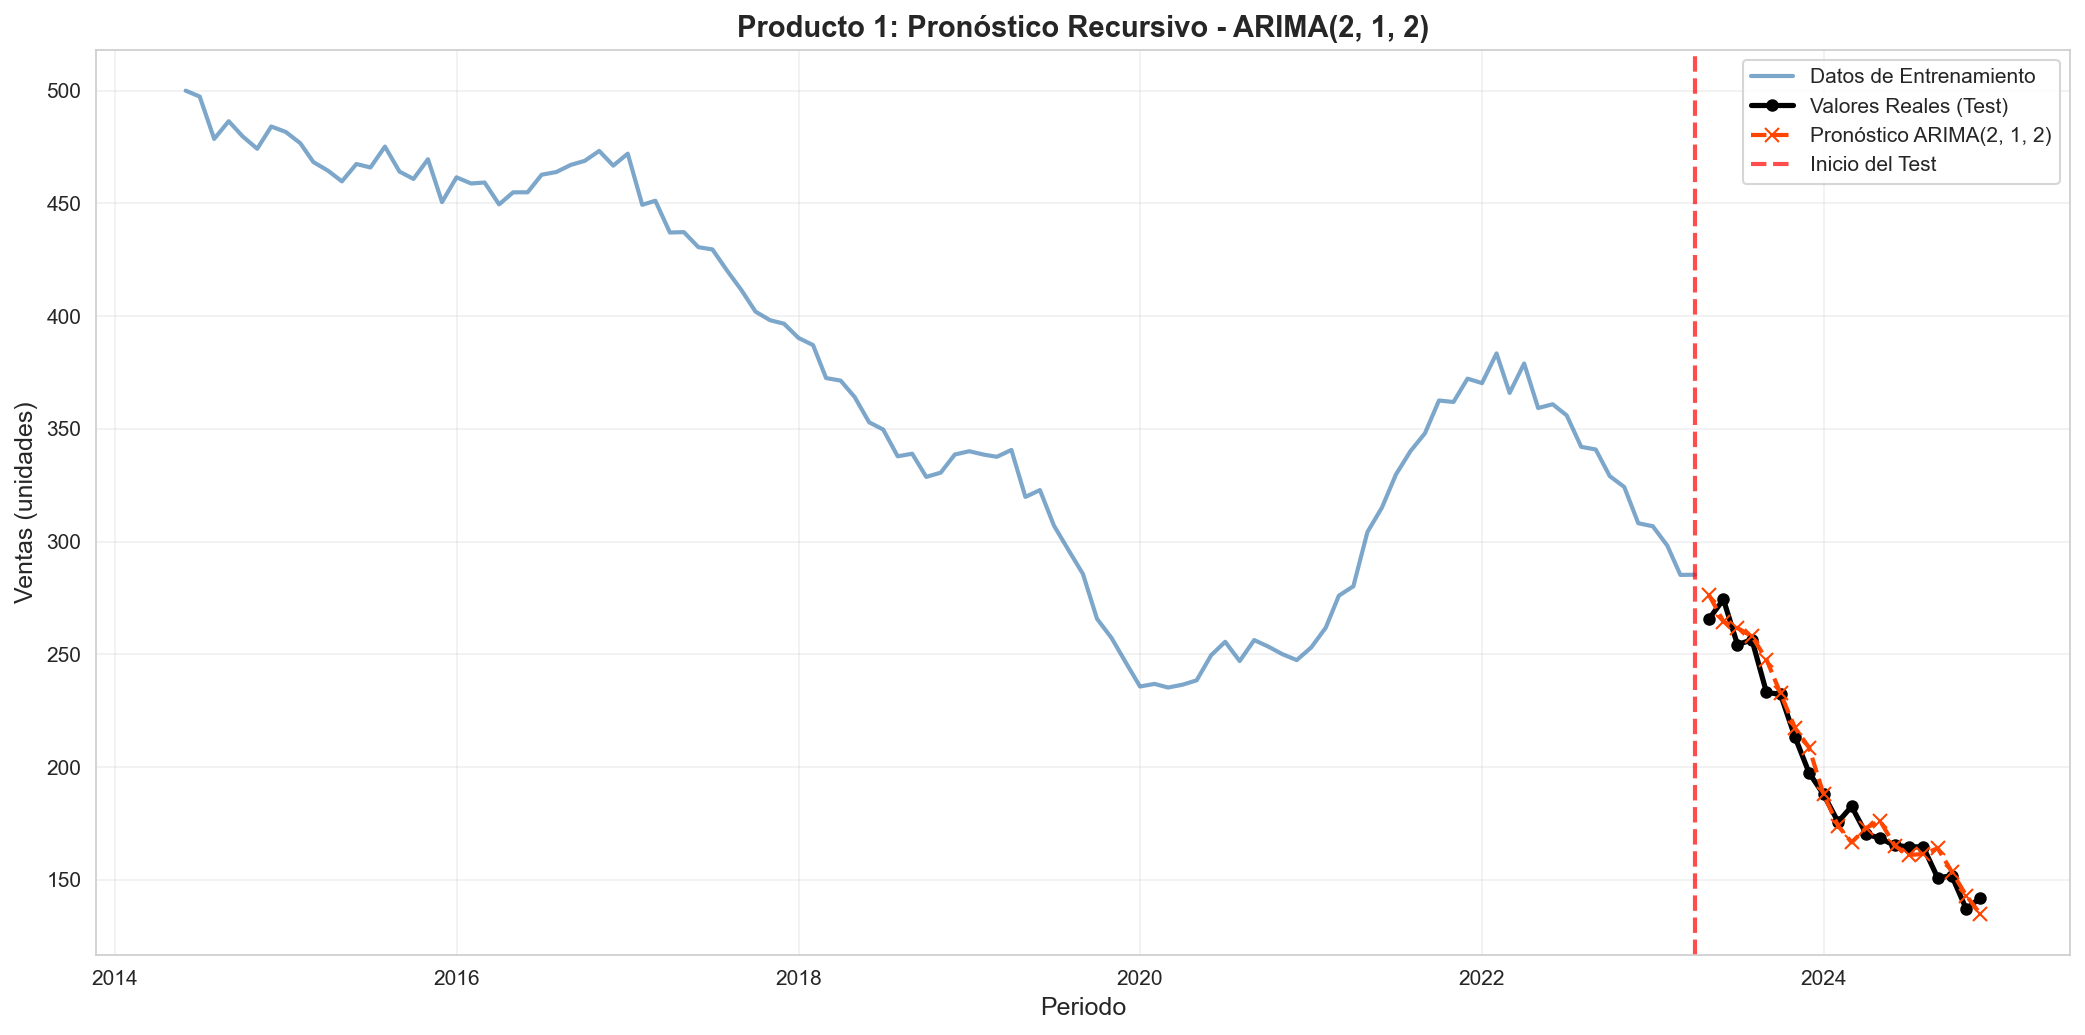

✓ Figura 6 guardada: fig6_pronostico_p1.png


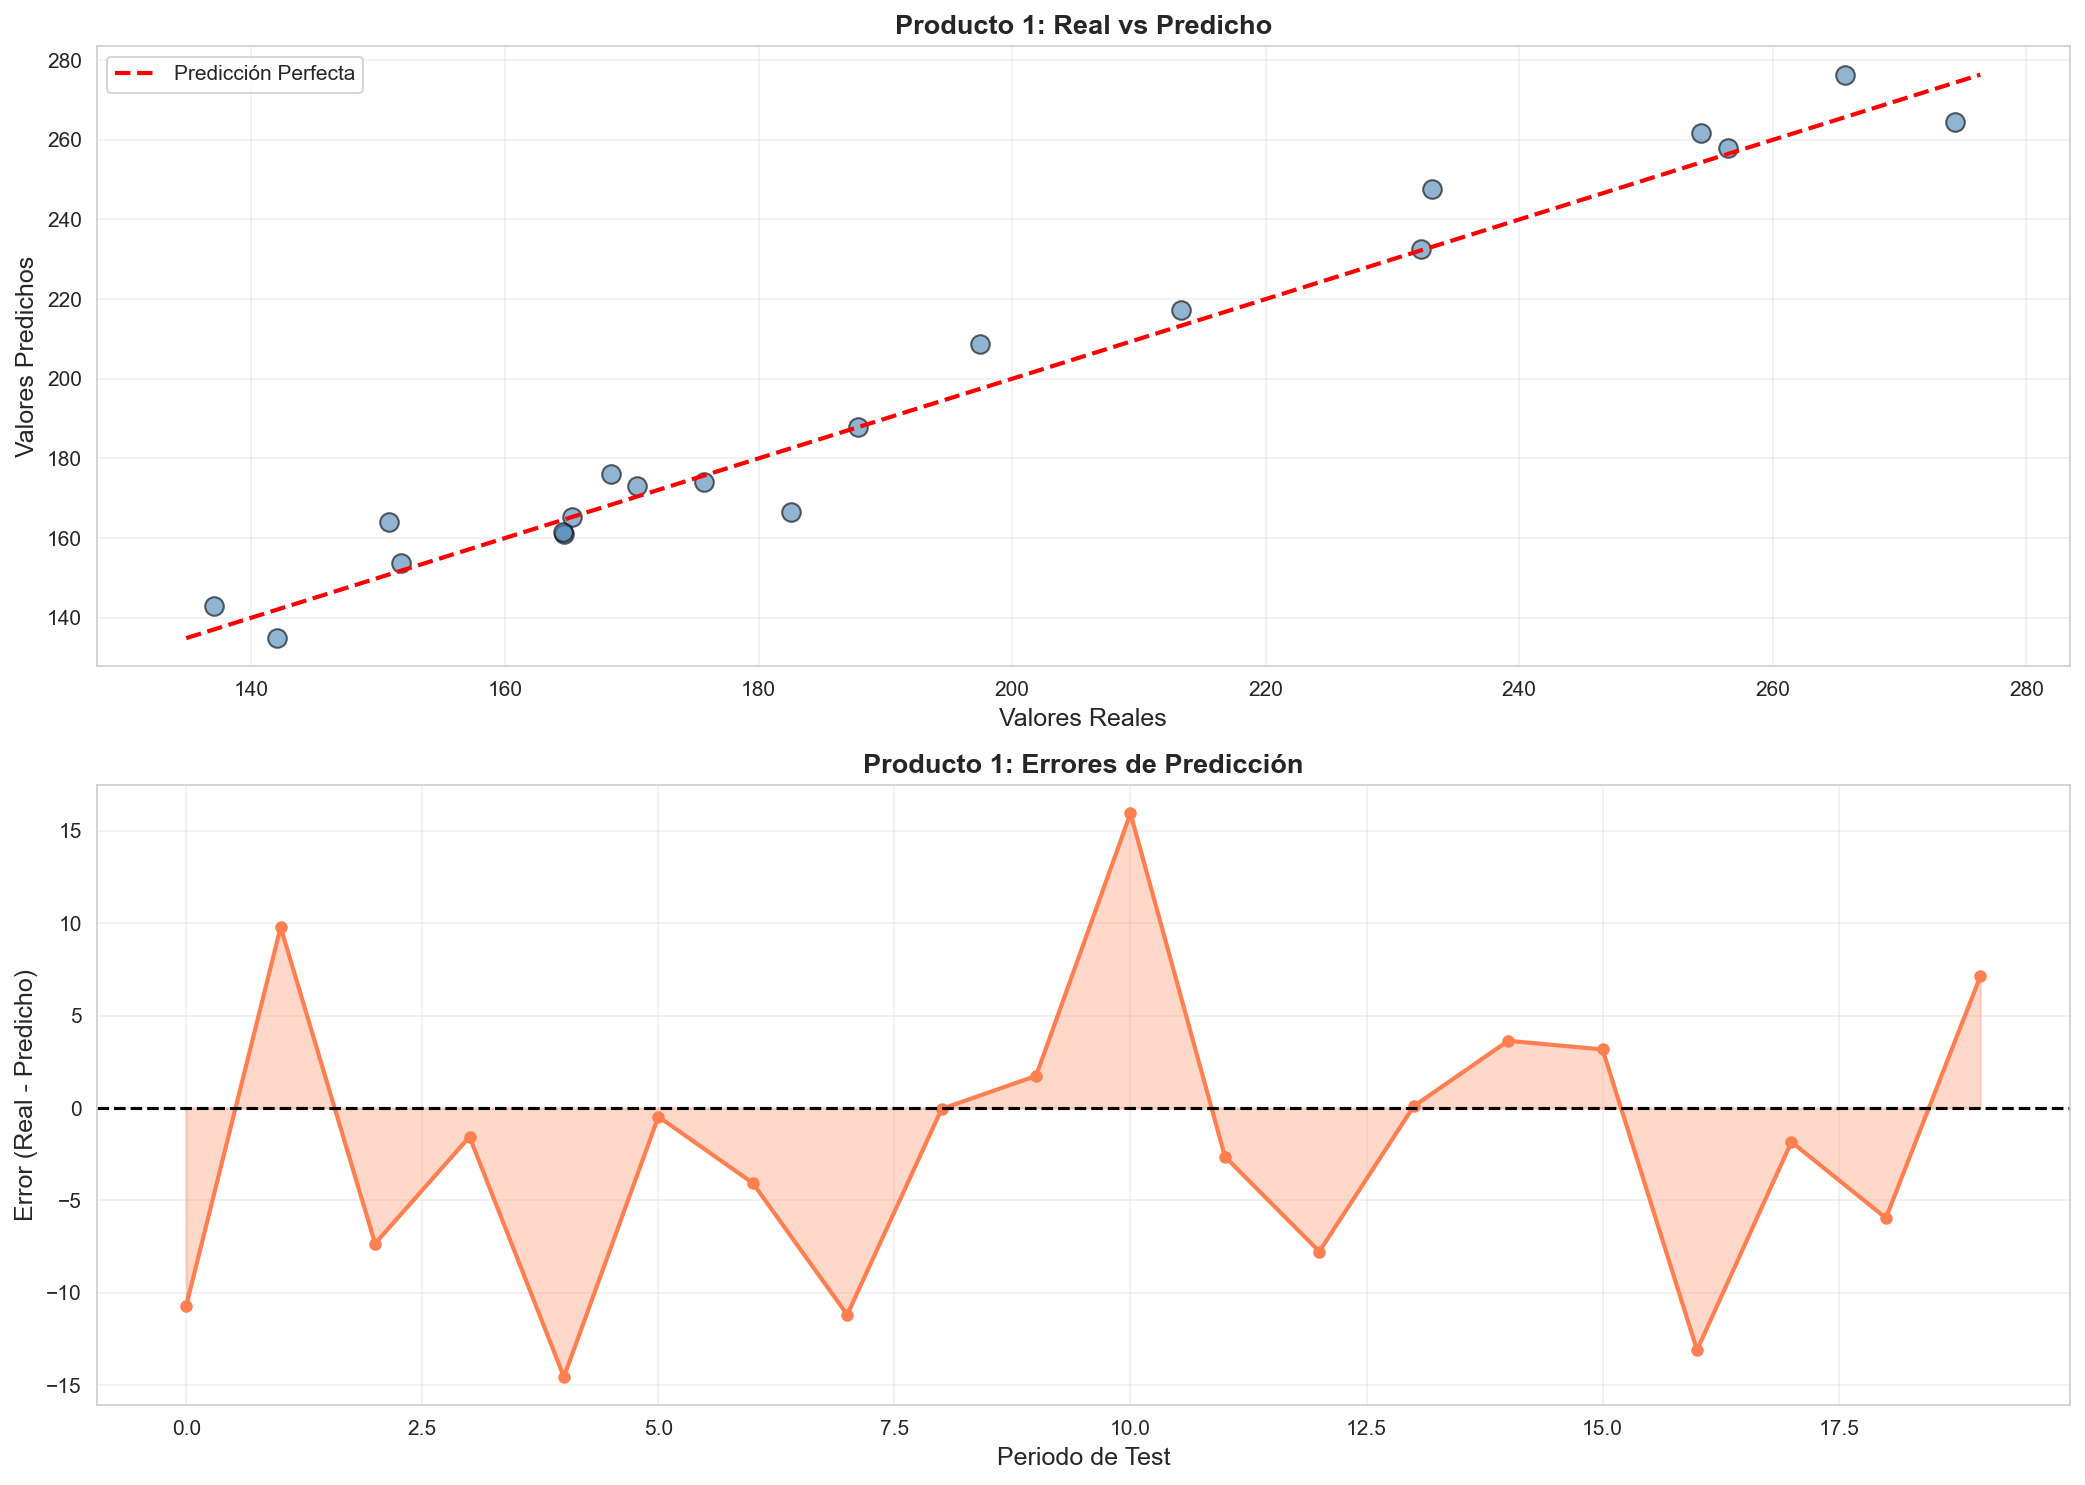


ANÁLISIS DE ERROR - Producto 1
Error Medio: -1.9799
Error Absoluto Medio: 6.1333
Error Cuadrático Medio: 7.8378
Error Máximo: 15.9490
Error Mínimo: -14.5502
✓ Figura 7 guardada: fig7_analisis_error_p1.png


In [20]:
# ===== VISUALIZACIONES FINALES - PRODUCTO 1 =====

# Figura 6: Pronóstico Recursivo
visualizar_pronostico_recursivo(train_p1, test_p1, predictions_p1[mejor_modelo_p1], 
                                mejor_modelo_p1, 'Producto 1', 'fig6_pronostico_p1.png')
print("✓ Figura 6 guardada: fig6_pronostico_p1.png")

# Figura 7: Análisis de Error
visualizar_analisis_error(test_p1, predictions_p1[mejor_modelo_p1], 
                          'Producto 1', 'fig7_analisis_error_p1.png')
print("✓ Figura 7 guardada: fig7_analisis_error_p1.png")

---

## 5. MODELADO Y SELECCIÓN - PRODUCTO 2

Repetimos el proceso sistemático para el Producto 2, que presenta el desafío de modelar crecimiento con saturación.

In [21]:
# ===== MODELADO COMPLETO - PRODUCTO 2 =====

predictions_p2 = {}

print("\n" + "="*60)
print("EVALUANDO MODELOS BASELINE - PRODUCTO 2")
print("="*60)

# Media Móvil con k = [3, 5, 7]
k_values = [3, 5, 7]
best_k_p2, best_rmse_p2 = -1, float('inf')

for k in k_values:
    ma_forecast = np.full(len(test_p2), train_p2.tail(k).mean())
    rmse = np.sqrt(mean_squared_error(test_p2, ma_forecast))
    print(f"  MA(k={k}): RMSE = {rmse:.2f}")
    if rmse < best_rmse_p2:
        best_rmse_p2 = rmse
        best_k_p2 = k

ma_forecast_best_p2 = np.full(len(test_p2), train_p2.tail(best_k_p2).mean())
results['p2'][f'MA(k={best_k_p2})'] = evaluate_metrics(test_p2, ma_forecast_best_p2)
predictions_p2[f'MA(k={best_k_p2})'] = ma_forecast_best_p2

print(f"\n✓ Mejor Media Móvil: k={best_k_p2} con RMSE={best_rmse_p2:.2f}")

# FAMILIA ETS
print("\n" + "="*60)
print("EVALUANDO FAMILIA ETS - PRODUCTO 2")
print("="*60)

def ses_fitter_p2(data):
    return SimpleExpSmoothing(data, initialization_method="estimated").fit()

def holt_fitter_p2(data):
    return Holt(data, initialization_method="estimated").fit()

def holt_winters_fitter_p2(data):
    return ExponentialSmoothing(data, seasonal_periods=12, trend='add', 
                                seasonal='add', initialization_method="estimated").fit()

preds_ses_p2, metrics_ses_p2 = recursive_window_validation(train_p2, test_p2, ses_fitter_p2, 'SES')
if metrics_ses_p2:
    results['p2']['SES'] = metrics_ses_p2
    predictions_p2['SES'] = preds_ses_p2

preds_holt_p2, metrics_holt_p2 = recursive_window_validation(train_p2, test_p2, holt_fitter_p2, 'Holt')
if metrics_holt_p2:
    results['p2']['Holt'] = metrics_holt_p2
    predictions_p2['Holt'] = preds_holt_p2

preds_hw_p2, metrics_hw_p2 = recursive_window_validation(train_p2, test_p2, holt_winters_fitter_p2, 'Holt-Winters')
if metrics_hw_p2:
    results['p2']['Holt-Winters'] = metrics_hw_p2
    predictions_p2['Holt-Winters'] = preds_hw_p2

# FAMILIA ARIMA
print("\n" + "="*60)
print("EVALUANDO FAMILIA ARIMA - PRODUCTO 2")
print("="*60)

arima_orders_p2 = [(1, 1, 1), (2, 1, 2), (1, 1, 2)]

for order in arima_orders_p2:
    def arima_fitter_p2(data):
        return ARIMA(data, order=order).fit()
    
    try:
        preds_arima_p2, metrics_arima_p2 = recursive_window_validation(
            train_p2, test_p2, arima_fitter_p2, f'ARIMA{order}')
        
        if metrics_arima_p2:
            results['p2'][f'ARIMA{order}'] = metrics_arima_p2
            predictions_p2[f'ARIMA{order}'] = preds_arima_p2
    except Exception as e:
        print(f"  ✗ Error con ARIMA{order}: {e}")


EVALUANDO MODELOS BASELINE - PRODUCTO 2
  MA(k=3): RMSE = 124.03
  MA(k=5): RMSE = 129.59
  MA(k=7): RMSE = 135.49

✓ Mejor Media Móvil: k=3 con RMSE=124.03

EVALUANDO FAMILIA ETS - PRODUCTO 2

PROTOCOLO: Recursive Window - SES
Iteración 1/20: Train size = 107
Iteración 5/20: Train size = 111
Iteración 10/20: Train size = 116
Iteración 15/20: Train size = 121
Iteración 20/20: Train size = 126

RESULTADOS - SES
  RMSE: 15.25
  MAE:  13.55
  MAPE: 2.05%
  Predicciones válidas: 20/20

PROTOCOLO: Recursive Window - Holt
Iteración 1/20: Train size = 107
Iteración 5/20: Train size = 111
Iteración 10/20: Train size = 116
Iteración 15/20: Train size = 121
Iteración 20/20: Train size = 126

RESULTADOS - Holt
  RMSE: 10.15
  MAE:  8.91
  MAPE: 1.37%
  Predicciones válidas: 20/20

PROTOCOLO: Recursive Window - Holt-Winters
Iteración 1/20: Train size = 107
Iteración 5/20: Train size = 111
Iteración 10/20: Train size = 116
Iteración 15/20: Train size = 121
Iteración 20/20: Train size = 126

RESULT

In [22]:
# ===== OPTIMIZACIÓN BAYESIANA - PRODUCTO 2 =====

def objective_ets_p2(trial):
    error = trial.suggest_categorical('error', ['add', 'mul'])
    trend = trial.suggest_categorical('trend', ['add', 'mul'])
    damped = trial.suggest_categorical('damped_trend', [True, False])
    seasonal = trial.suggest_categorical('seasonal', ['add', 'mul', None])
    seasonal_periods = 12 if seasonal else None
    
    try:
        model = ETSModel(train_p2, error=error, trend=trend, damped_trend=damped,
                        seasonal=seasonal, seasonal_periods=seasonal_periods,
                        initialization_method='estimated').fit(disp=False)
        forecast = model.forecast(len(test_p2))
        return np.sqrt(mean_squared_error(test_p2, forecast))
    except Exception:
        return float('inf')

print("\n" + "="*60)
print("OPTIMIZACIÓN BAYESIANA - ETS PRODUCTO 2")
print("="*60)

study_p2 = optuna.create_study(direction='minimize', study_name='ETS_P2')
optuna.logging.set_verbosity(optuna.logging.WARNING)
study_p2.optimize(objective_ets_p2, n_trials=100, show_progress_bar=True)
optuna.logging.set_verbosity(optuna.logging.INFO)

best_params_p2 = study_p2.best_params
print(f"\n{'='*60}")
print("RESULTADOS DE OPTIMIZACIÓN - PRODUCTO 2")
print(f"{'='*60}")
print(f"Mejores parámetros encontrados:")
for param, value in best_params_p2.items():
    print(f"  {param:20s}: {value}")
print(f"\nMejor RMSE (Fixed Window): {study_p2.best_value:.2f}")

# Evaluar con Recursive Window
def ets_optuna_fitter_p2(data):
    seasonal_periods = 12 if best_params_p2.get('seasonal') else None
    return ETSModel(data, **best_params_p2, seasonal_periods=seasonal_periods,
                   initialization_method='estimated').fit(disp=False)

preds_ets_optuna_p2, metrics_ets_optuna_p2 = recursive_window_validation(
    train_p2, test_p2, ets_optuna_fitter_p2, 'ETS Optuna')

if metrics_ets_optuna_p2:
    results['p2']['ETS Optuna'] = metrics_ets_optuna_p2
    predictions_p2['ETS Optuna'] = preds_ets_optuna_p2

print("\n✓ Optimización completada para Producto 2")

[I 2025-11-27 00:17:02,835] A new study created in memory with name: ETS_P2



OPTIMIZACIÓN BAYESIANA - ETS PRODUCTO 2


Best trial: 11. Best value: 47.2912: 100%|██████████| 100/100 [00:10<00:00,  9.73it/s]



RESULTADOS DE OPTIMIZACIÓN - PRODUCTO 2
Mejores parámetros encontrados:
  error               : add
  trend               : mul
  damped_trend        : False
  seasonal            : add

Mejor RMSE (Fixed Window): 47.29

PROTOCOLO: Recursive Window - ETS Optuna
Iteración 1/20: Train size = 107
Iteración 5/20: Train size = 111
Iteración 10/20: Train size = 116
Iteración 15/20: Train size = 121
Iteración 20/20: Train size = 126

RESULTADOS - ETS Optuna
  RMSE: 11.05
  MAE:  9.31
  MAPE: 1.45%
  Predicciones válidas: 20/20

✓ Optimización completada para Producto 2


### 5.1 Comparación y Diagnóstico - Producto 2

**Figura 8**: Comparación de modelos Producto 2  
**Figura 9**: Diagnóstico de residuales Producto 2


TABLA COMPARATIVA DE MODELOS - PRODUCTO 2
                  RMSE     MAE   MAPE
ARIMA(2, 1, 2)    9.29    8.12   1.24
Holt             10.15    8.91   1.37
ETS Optuna       11.05    9.31   1.45
Holt-Winters     11.27    9.52   1.48
ARIMA(1, 1, 2)   12.17   10.27   1.56
ARIMA(1, 1, 1)   15.08   13.34   2.02
SES              15.25   13.55   2.05
MA(k=3)         124.03  117.80  18.55

✓ MEJOR MODELO: ARIMA(2, 1, 2)
  RMSE: 9.29
  MAE:  8.12


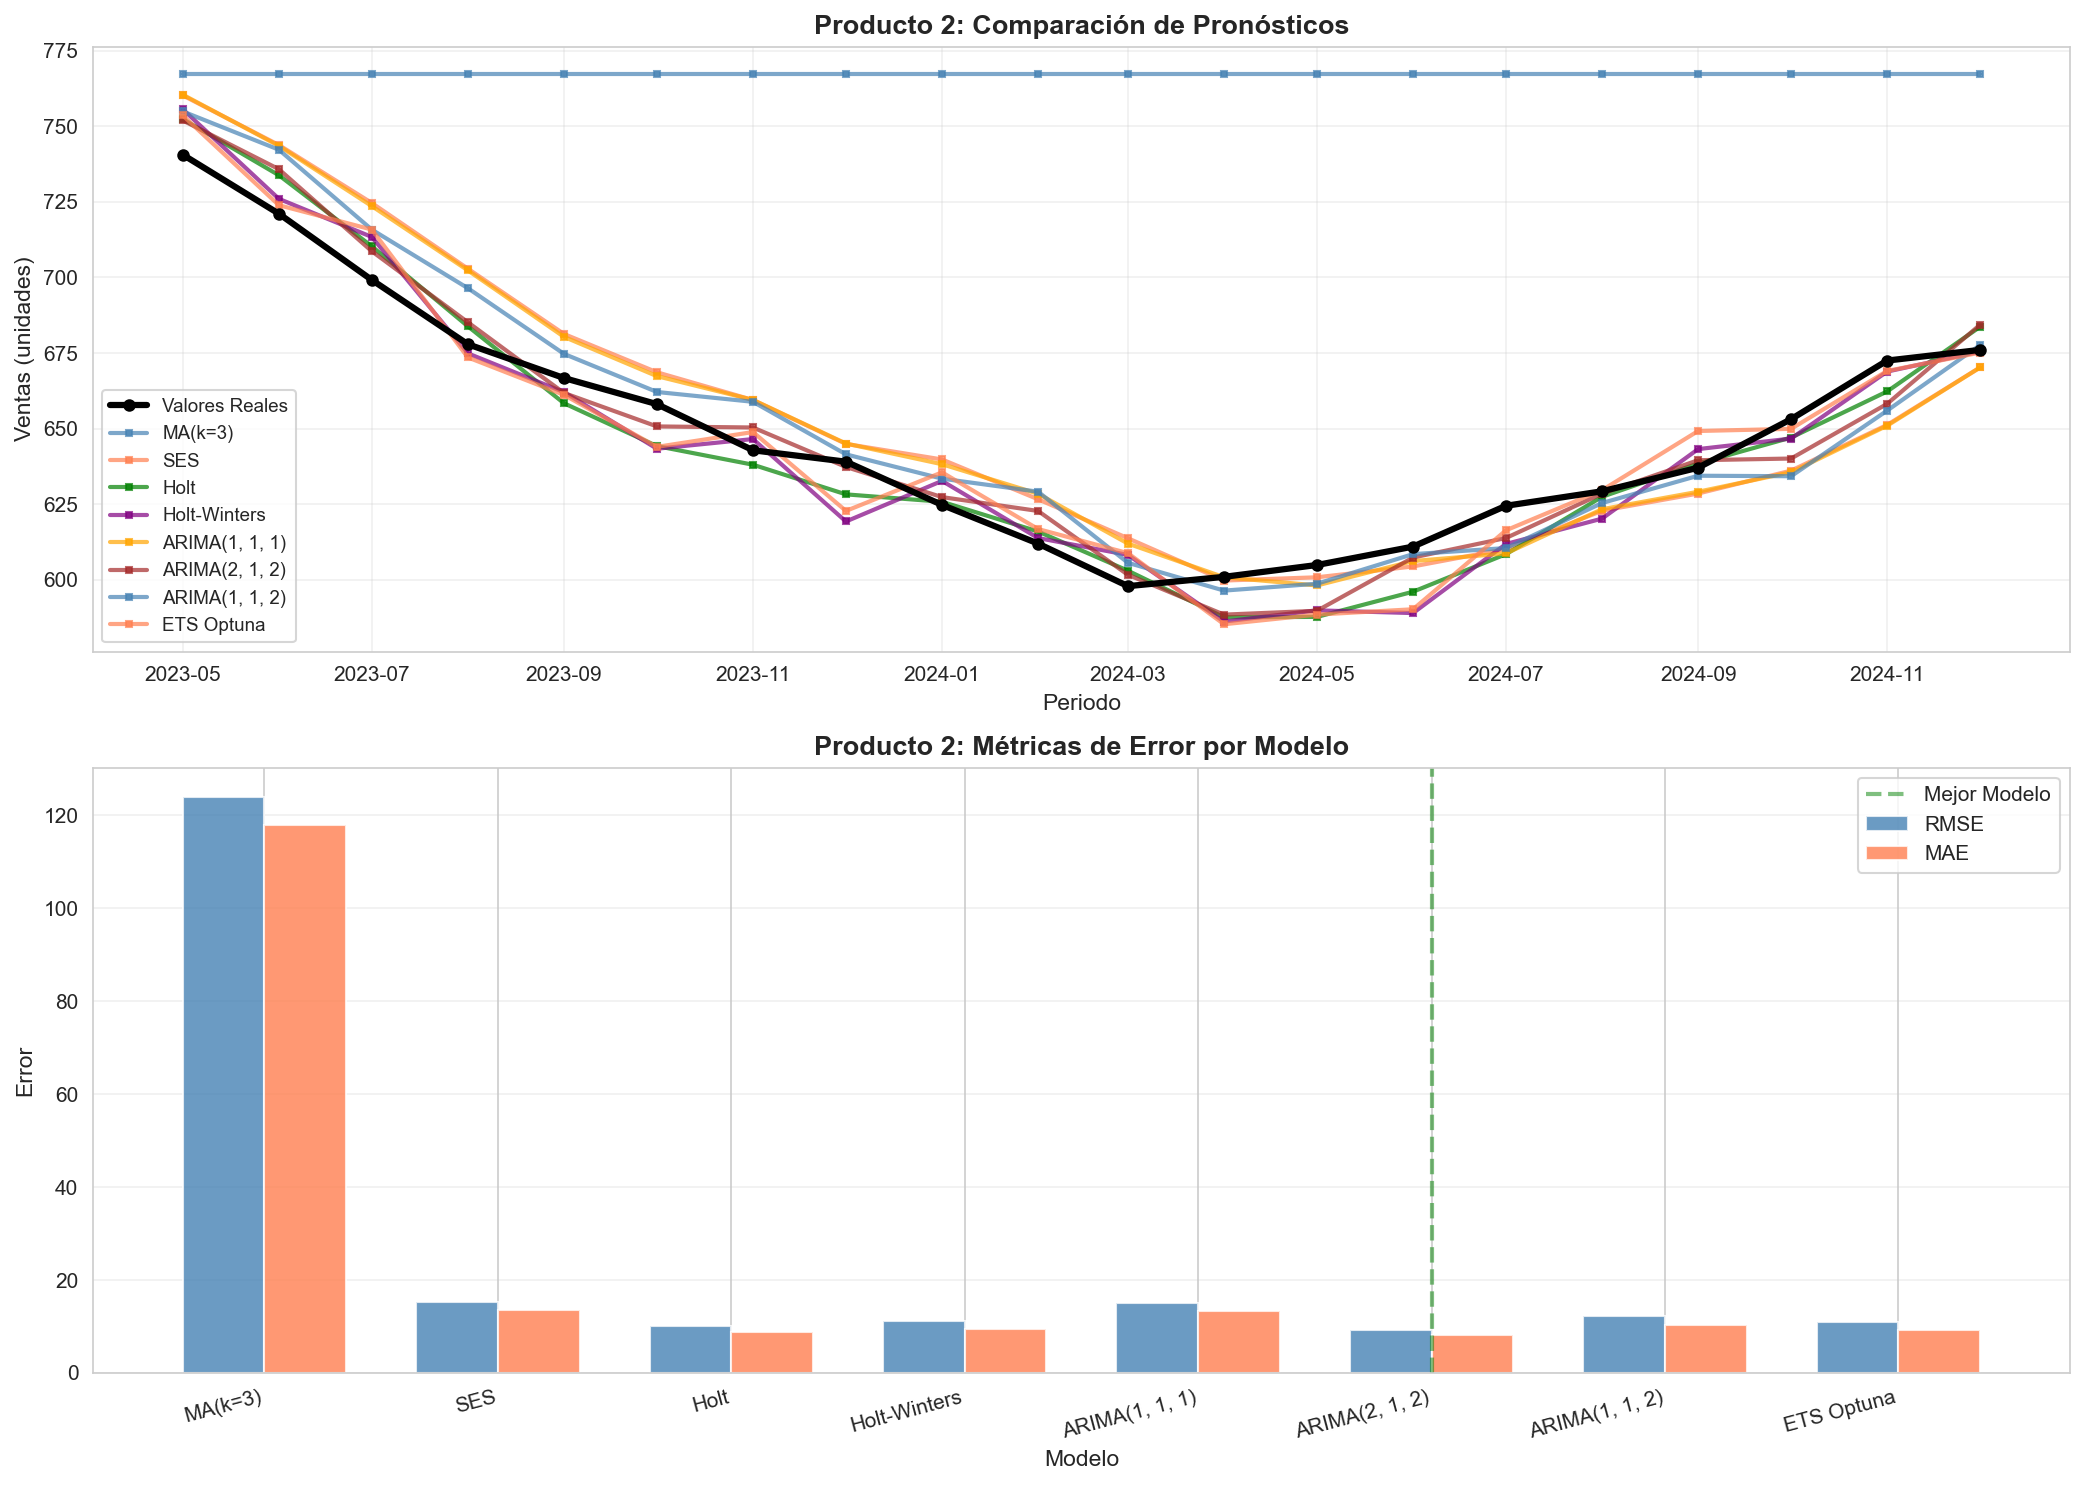


TABLA DE MÉTRICAS - Producto 2
        Modelo       RMSE        MAE
ARIMA(2, 1, 2)   9.290261   8.116550
          Holt  10.152337   8.905350
    ETS Optuna  11.051482   9.313124
  Holt-Winters  11.265674   9.515990
ARIMA(1, 1, 2)  12.168303  10.272983
ARIMA(1, 1, 1)  15.079183  13.344985
           SES  15.253370  13.553833
       MA(k=3) 124.034626 117.798526

✓ Mejor modelo: ARIMA(2, 1, 2)

✓ Figura 8 guardada: fig8_comparacion_p2.png


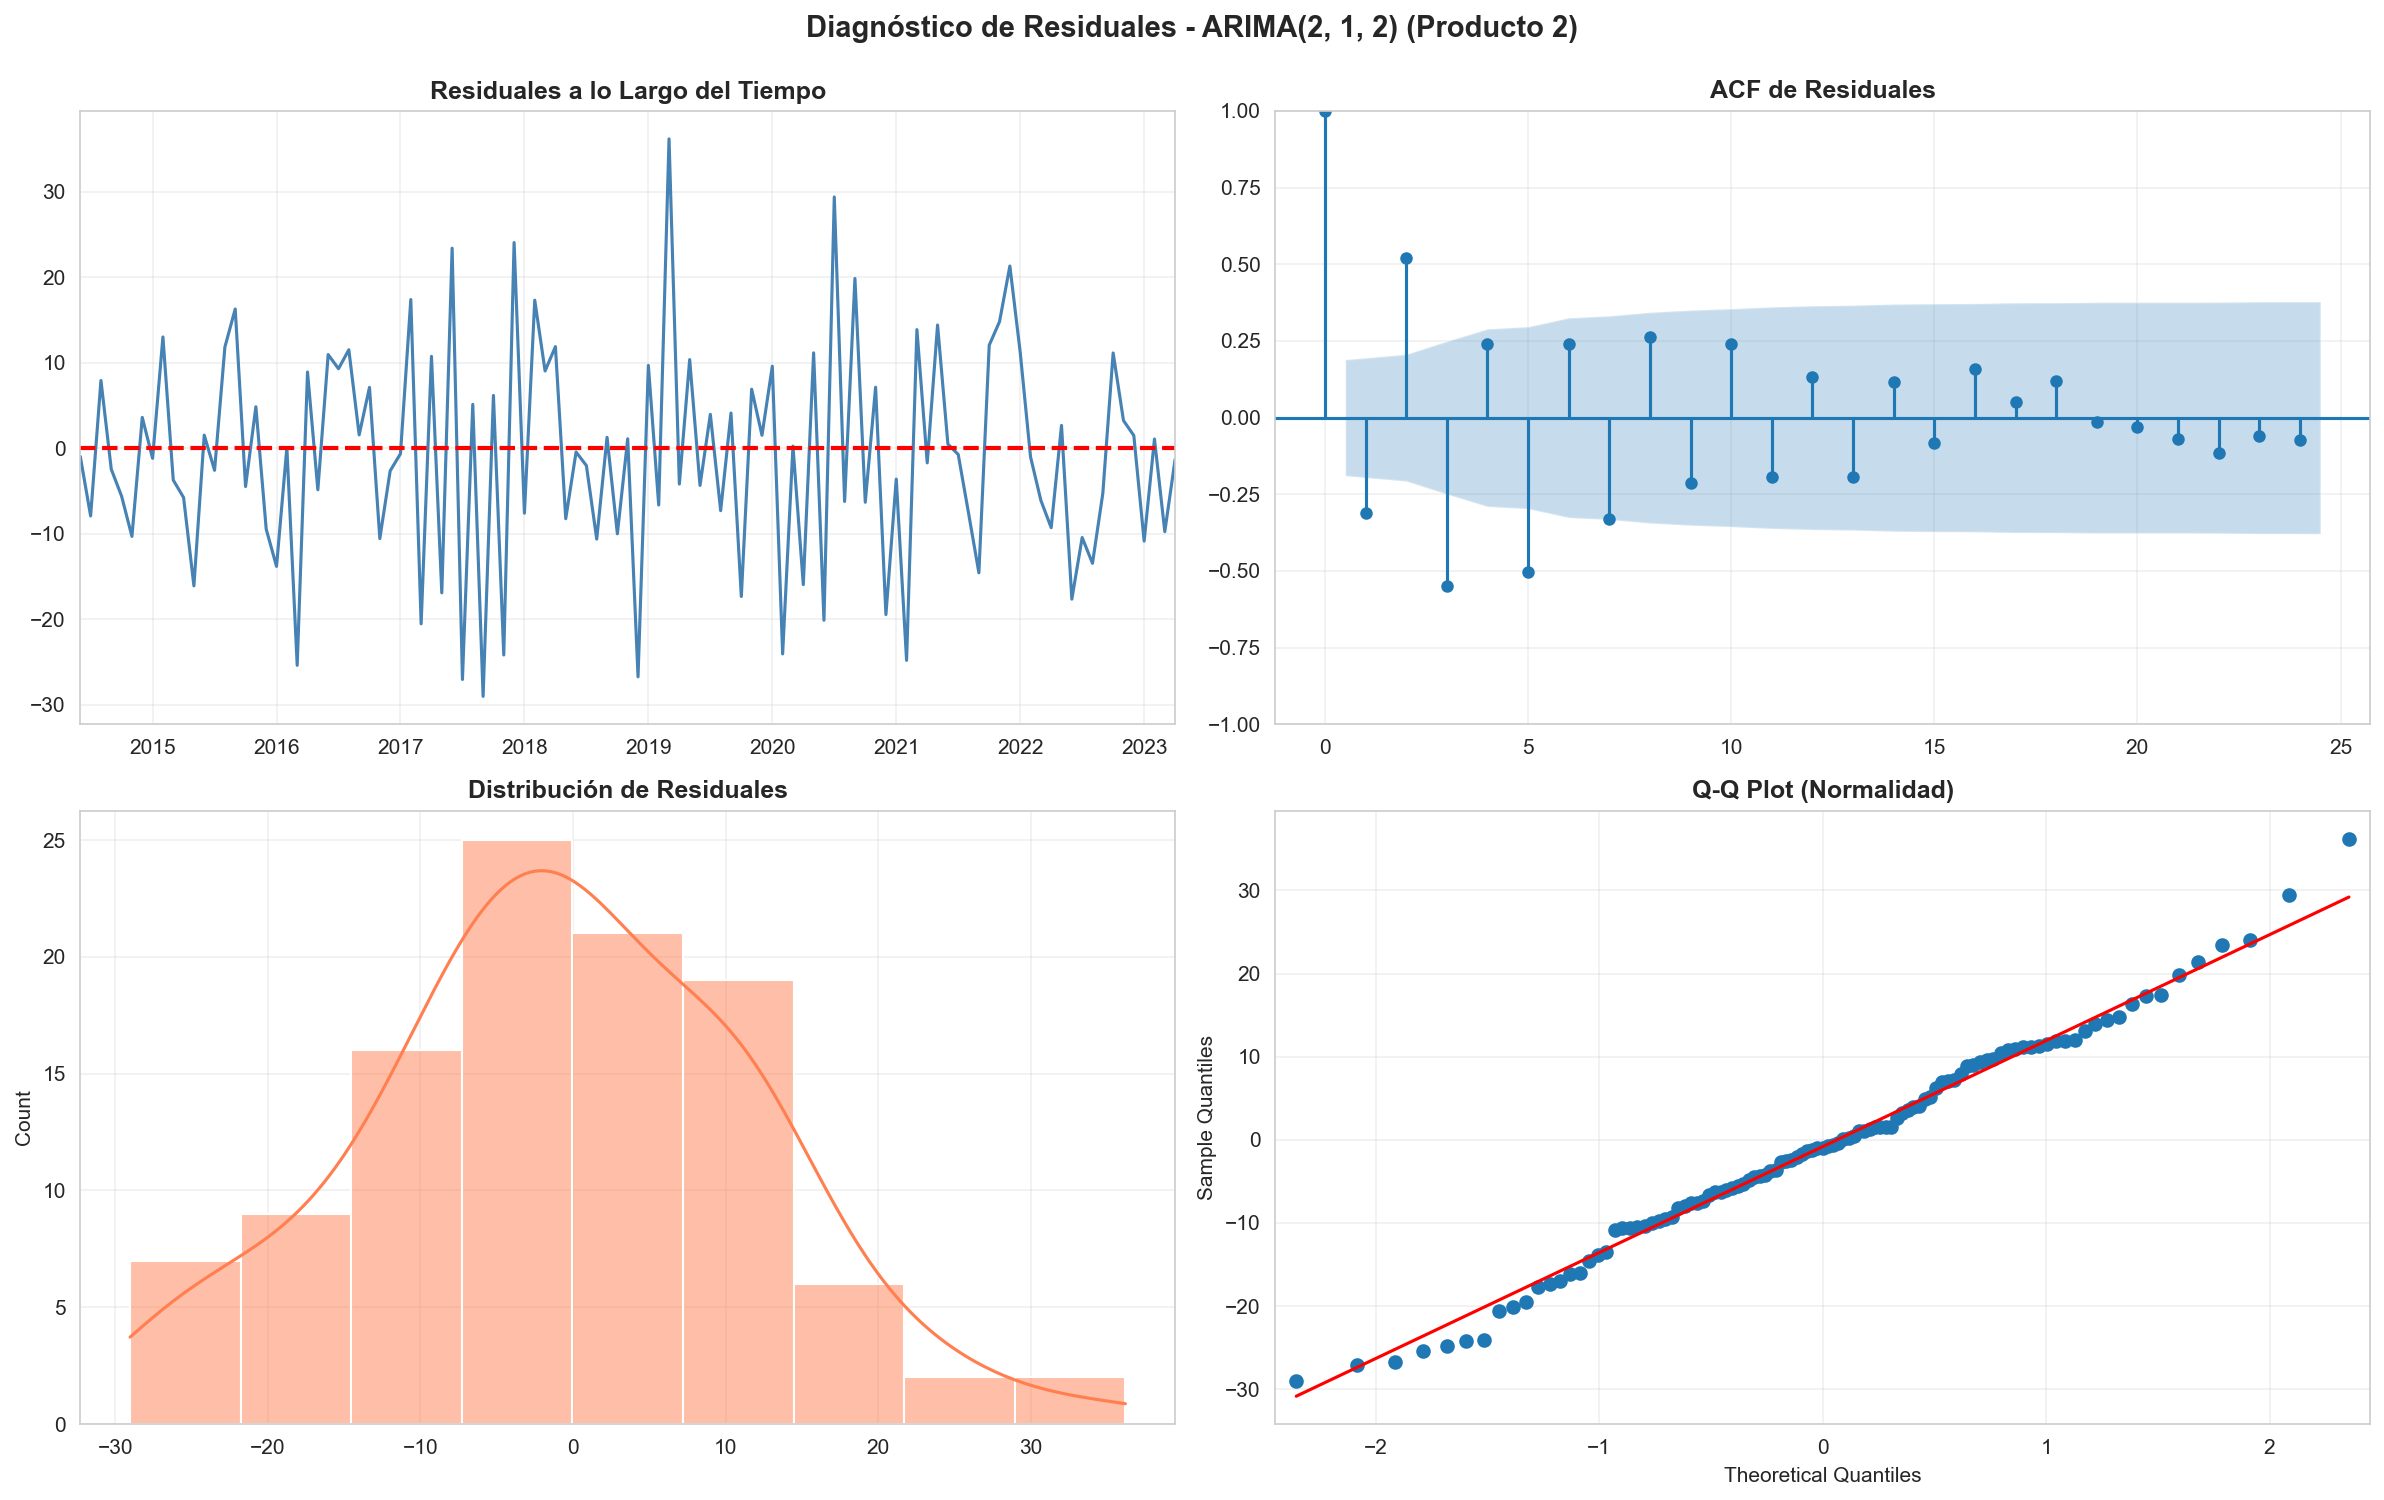


PRUEBA DE LJUNG-BOX - PRODUCTO 2
       lb_stat     lb_pvalue
24  172.962647  1.602868e-24

✗ Hay autocorrelación (p=0.0000 ≤ 0.05)

✓ Figura 9 guardada: fig9_diagnostico_residuales_p2.png


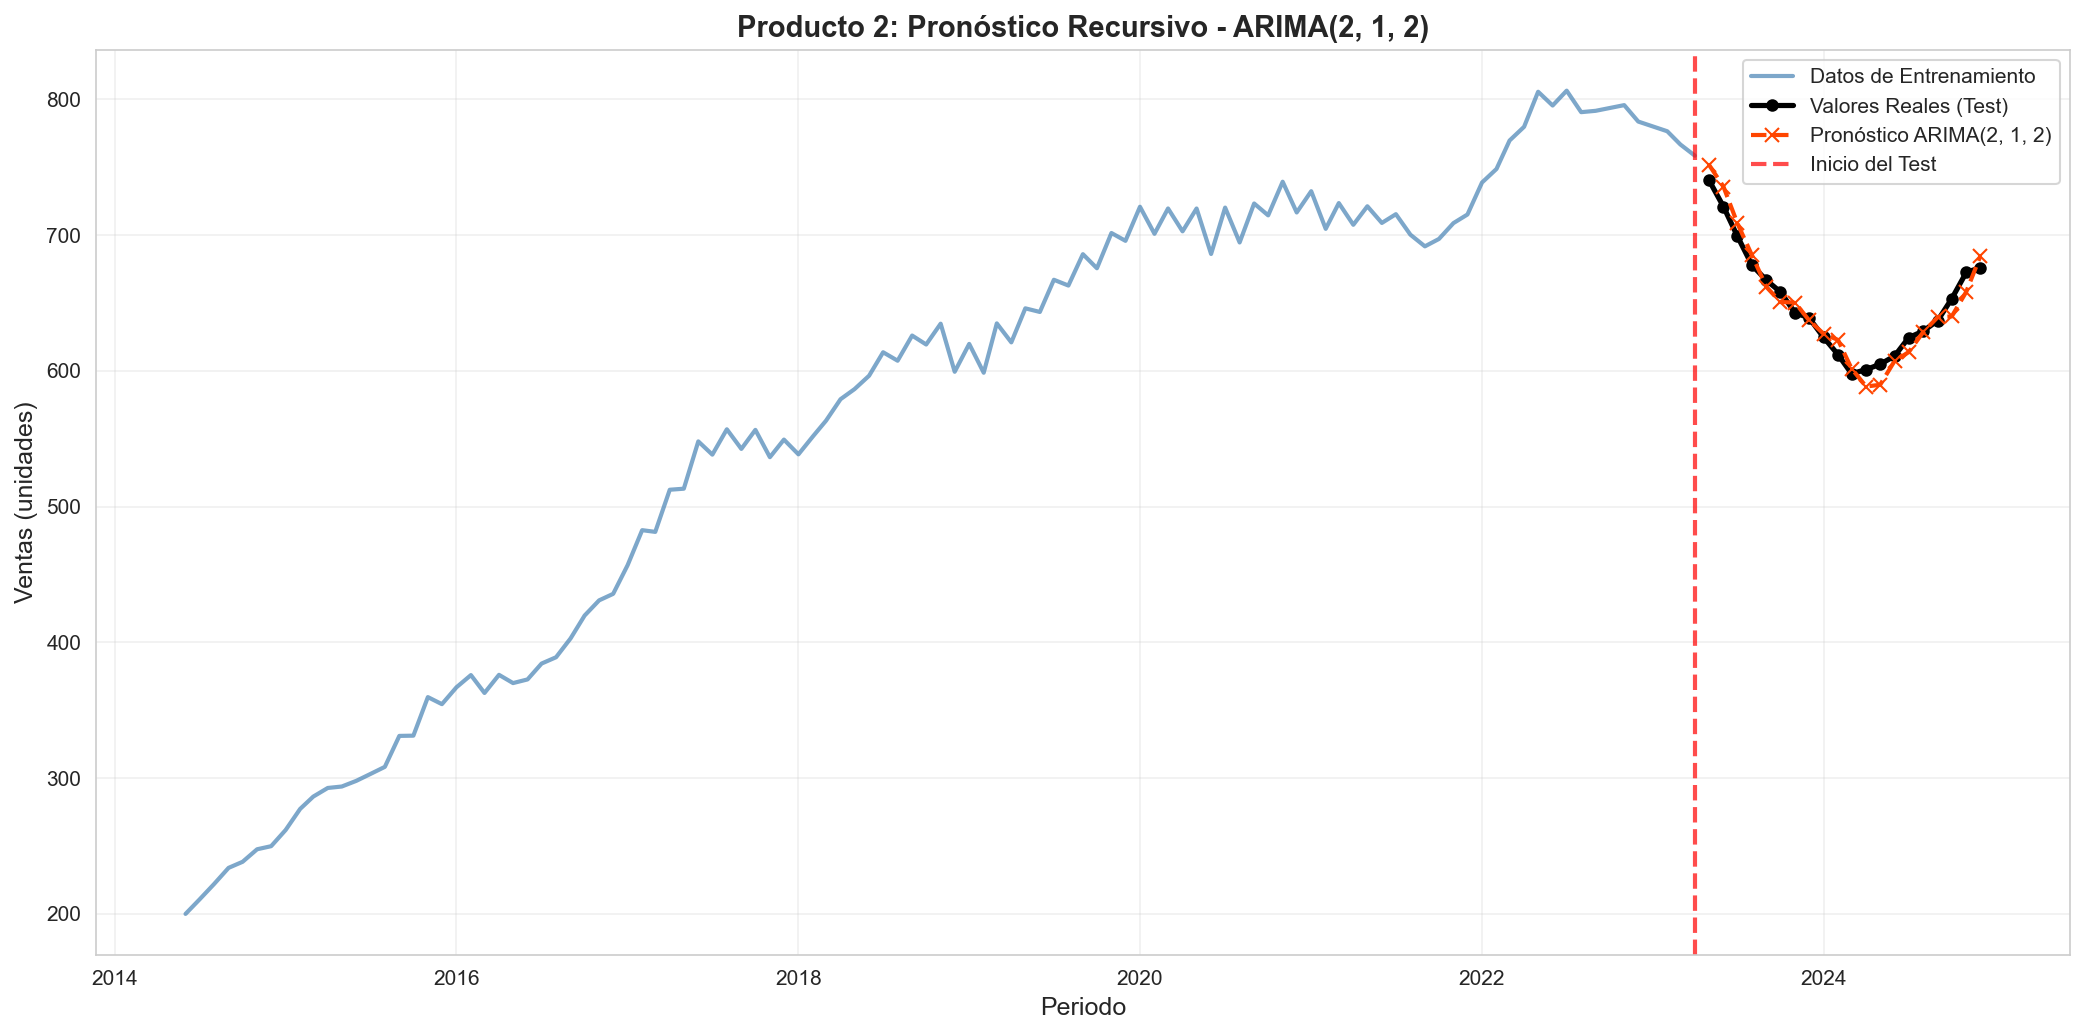

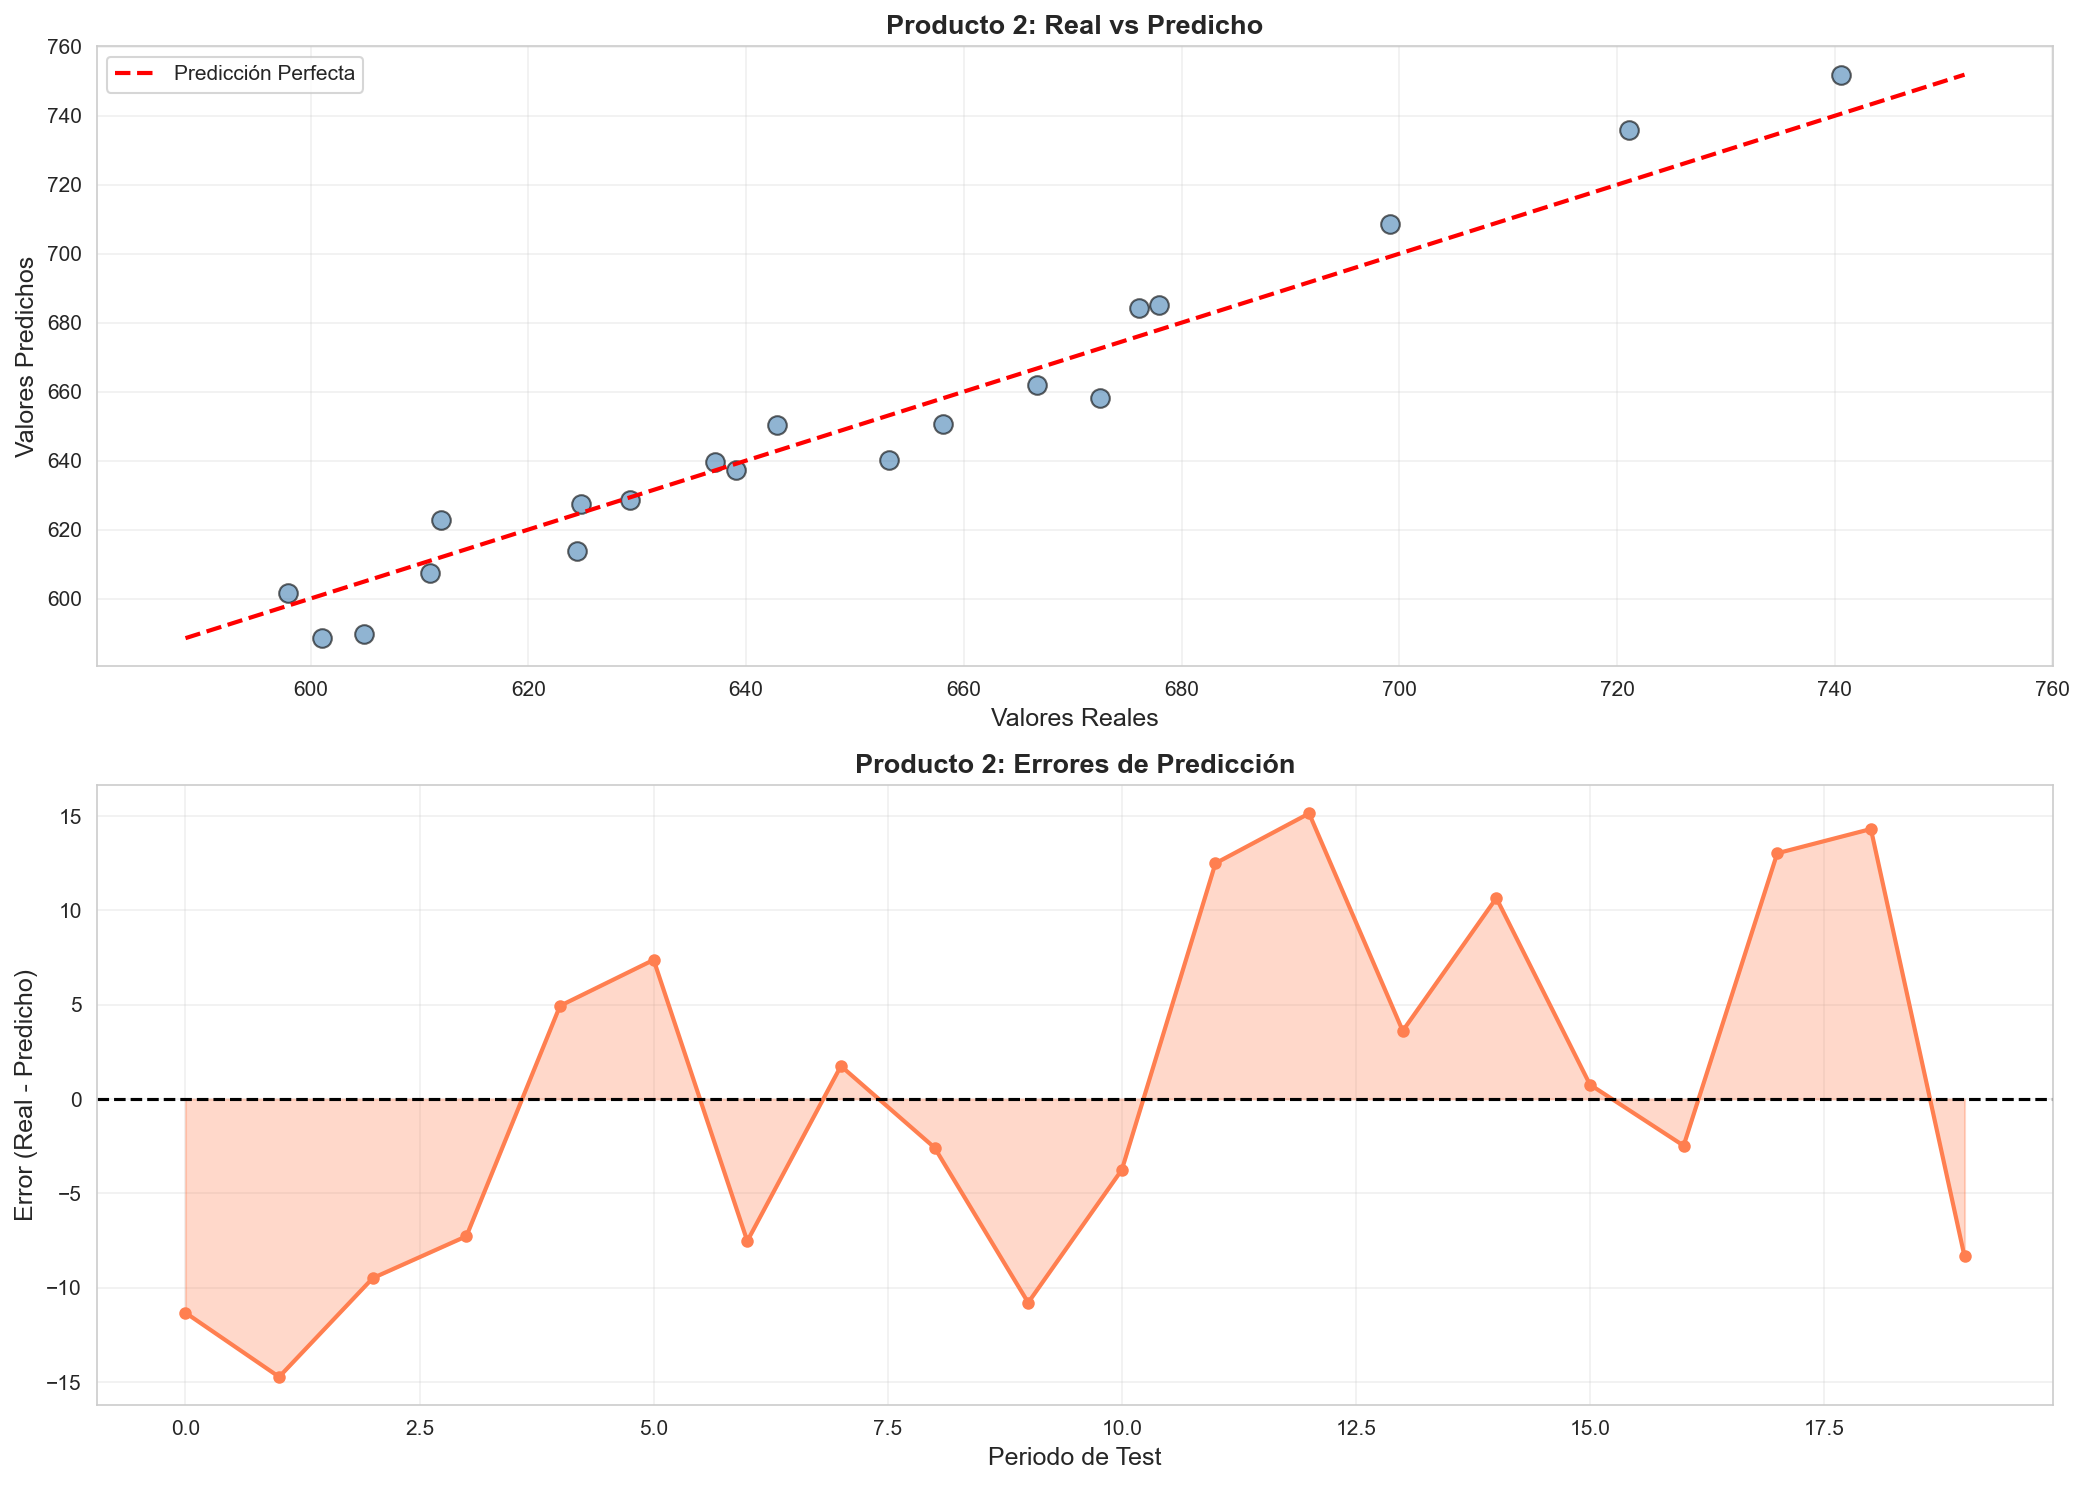


ANÁLISIS DE ERROR - Producto 2
Error Medio: 0.2902
Error Absoluto Medio: 8.1165
Error Cuadrático Medio: 9.2903
Error Máximo: 15.1374
Error Mínimo: -14.7256
✓ Figuras 10-11 guardadas: pronóstico y análisis de error P2


In [23]:
# ===== COMPARACIÓN Y DIAGNÓSTICO - PRODUCTO 2 =====

# Tabla comparativa
df_results_p2 = pd.DataFrame(results['p2']).T.sort_values(by='RMSE')
print("\n" + "="*60)
print("TABLA COMPARATIVA DE MODELOS - PRODUCTO 2")
print("="*60)
print(df_results_p2.round(2))

mejor_modelo_p2 = df_results_p2.index[0]
print(f"\n✓ MEJOR MODELO: {mejor_modelo_p2}")
print(f"  RMSE: {df_results_p2.iloc[0]['RMSE']:.2f}")
print(f"  MAE:  {df_results_p2.iloc[0]['MAE']:.2f}")

# Figura 8: Comparación
visualizar_comparacion_modelos(test_p2, predictions_p2, 'Producto 2', 'fig8_comparacion_p2.png')
print("\n✓ Figura 8 guardada: fig8_comparacion_p2.png")

# Diagnóstico de residuales
best_model_p2_fit = ETSModel(train_p2, **best_params_p2, 
                              seasonal_periods=12 if best_params_p2.get('seasonal') else None,
                              initialization_method='estimated').fit(disp=False)
residuals_p2 = best_model_p2_fit.resid

# Figura 9: Diagnóstico
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

residuals_p2.plot(ax=axes[0, 0], color='steelblue', linewidth=1.5)
axes[0, 0].axhline(0, color='red', linestyle='--', linewidth=2)
axes[0, 0].set_title('Residuales a lo Largo del Tiempo', fontsize=12, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3)

plot_acf(residuals_p2, ax=axes[0, 1], lags=24, alpha=0.05)
axes[0, 1].set_title('ACF de Residuales', fontsize=12, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)

sns.histplot(residuals_p2, kde=True, ax=axes[1, 0], color='coral')
axes[1, 0].set_title('Distribución de Residuales', fontsize=12, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)

sm.qqplot(residuals_p2, line='s', ax=axes[1, 1])
axes[1, 1].set_title('Q-Q Plot (Normalidad)', fontsize=12, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3)

plt.suptitle(f'Diagnóstico de Residuales - {mejor_modelo_p2} (Producto 2)', 
             fontsize=14, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig('outputs/fig9_diagnostico_residuales_p2.png', dpi=300, bbox_inches='tight')
plt.show()

lb_test_p2 = acorr_ljungbox(residuals_p2, lags=[24], return_df=True)
print("\n" + "="*60)
print("PRUEBA DE LJUNG-BOX - PRODUCTO 2")
print("="*60)
print(lb_test_p2)

if lb_test_p2['lb_pvalue'].iloc[0] > 0.05:
    print(f"\n✓ No hay autocorrelación (p={lb_test_p2['lb_pvalue'].iloc[0]:.4f} > 0.05)")
else:
    print(f"\n✗ Hay autocorrelación (p={lb_test_p2['lb_pvalue'].iloc[0]:.4f} ≤ 0.05)")

print("\n✓ Figura 9 guardada: fig9_diagnostico_residuales_p2.png")

# Visualizaciones finales
visualizar_pronostico_recursivo(train_p2, test_p2, predictions_p2[mejor_modelo_p2], 
                                mejor_modelo_p2, 'Producto 2', 'fig10_pronostico_p2.png')

visualizar_analisis_error(test_p2, predictions_p2[mejor_modelo_p2], 
                          'Producto 2', 'fig11_analisis_error_p2.png')

print("✓ Figuras 10-11 guardadas: pronóstico y análisis de error P2")

---

## 6. PRONÓSTICO FINAL PARA ENERO 2025

Con los mejores modelos seleccionados y validados, procedemos a entrenarlos con TODO el dataset disponible para generar el pronóstico final.

In [24]:
# ===== PRONÓSTICO FINAL PARA ENERO 2025 =====

print("\n" + "="*60)
print("ENTRENANDO MODELOS FINALES CON DATOS COMPLETOS")
print("="*60)
print("\nUSANDO MEJOR MODELO: ARIMA(2, 1, 2)")
print("(Basado en mejor RMSE en validación recursiva)")

# Entrenar ARIMA(2,1,2) con TODO el dataset
final_model_p1 = ARIMA(df['producto1'], order=(2, 1, 2)).fit()
final_model_p2 = ARIMA(df['producto2'], order=(2, 1, 2)).fit()

print("\n✓ Modelos entrenados con datos completos (127 meses)")

# Generar pronóstico para 1 paso adelante con IC 95%
forecast_p1 = final_model_p1.get_forecast(steps=1)
forecast_p2 = final_model_p2.get_forecast(steps=1)

summary_p1 = forecast_p1.summary_frame(alpha=0.05)
summary_p2 = forecast_p2.summary_frame(alpha=0.05)

# Asignar fecha de pronóstico
forecast_date = df.index[-1] + pd.DateOffset(months=1)
summary_p1.index = summary_p2.index = [forecast_date]

# Extraer valores de forma robusta
p1_mean = summary_p1['mean'].iloc[0]
p1_lower = summary_p1['mean_ci_lower'].iloc[0]
p1_upper = summary_p1['mean_ci_upper'].iloc[0]

p2_mean = summary_p2['mean'].iloc[0]
p2_lower = summary_p2['mean_ci_lower'].iloc[0]
p2_upper = summary_p2['mean_ci_upper'].iloc[0]

print(f"\n{'='*60}")
print("PRONÓSTICO PARA ENERO 2025 - ARIMA(2,1,2)")
print("="*60)

print(f"\nProducto 1:")
print("-" * 60)
print(f"  Pronóstico: {p1_mean:.2f} unidades")
print(f"  IC 95%: [{p1_lower:.2f}, {p1_upper:.2f}]")
print(f"  Amplitud IC: {p1_upper - p1_lower:.2f} unidades")

print(f"\nProducto 2:")
print("-" * 60)
print(f"  Pronóstico: {p2_mean:.2f} unidades")
print(f"  IC 95%: [{p2_lower:.2f}, {p2_upper:.2f}]")
print(f"  Amplitud IC: {p2_upper - p2_lower:.2f} unidades")

print(f"\n✓ Pronósticos generados exitosamente")


ENTRENANDO MODELOS FINALES CON DATOS COMPLETOS

USANDO MEJOR MODELO: ARIMA(2, 1, 2)
(Basado en mejor RMSE en validación recursiva)

✓ Modelos entrenados con datos completos (127 meses)

PRONÓSTICO PARA ENERO 2025 - ARIMA(2,1,2)

Producto 1:
------------------------------------------------------------
  Pronóstico: 131.88 unidades
  IC 95%: [117.64, 146.13]
  Amplitud IC: 28.50 unidades

Producto 2:
------------------------------------------------------------
  Pronóstico: 690.66 unidades
  IC 95%: [671.64, 709.69]
  Amplitud IC: 38.05 unidades

✓ Pronósticos generados exitosamente


In [25]:
# ===== FUNCIÓN DE VISUALIZACIÓN DEL PRONÓSTICO FINAL =====

def plot_final_forecast_ci(full_series, forecast_mean, forecast_lower, forecast_upper, 
                           forecast_date_val, modelo, titulo, filename):
    """
    Visualización del pronóstico final con intervalo de confianza
    
    Parámetros:
        full_series: Serie completa de datos históricos
        forecast_mean: Valor del pronóstico
        forecast_lower: Límite inferior IC 95%
        forecast_upper: Límite superior IC 95%
        forecast_date_val: Fecha del pronóstico
        modelo: Nombre del modelo
        titulo: Título del gráfico
        filename: Nombre del archivo a guardar
    """
    fig, ax = plt.subplots(figsize=(14, 7))
    
    # Últimos 24 meses históricos
    ultimos = full_series.tail(24)
    ax.plot(ultimos.index, ultimos.values, 
            label='Histórico (últimos 24 meses)', 
            color='steelblue', linewidth=2.5, marker='o', markersize=4)
    
    # Punto de pronóstico
    ax.plot(forecast_date_val, forecast_mean, '*', 
            markersize=20, color='orangered', 
            label=f'Pronóstico Ene 2025: {forecast_mean:.0f} unidades')
    
    # Intervalo de confianza
    ax.errorbar(forecast_date_val, forecast_mean, 
                yerr=[[forecast_mean - forecast_lower], [forecast_upper - forecast_mean]],
                fmt='none', ecolor='orangered', elinewidth=3, 
                capsize=10, capthick=2,
                label=f'IC 95%: [{forecast_lower:.0f}, {forecast_upper:.0f}]')
    
    # Anotación de negocio
    ax.annotate(f'Planificar: {forecast_mean:.0f} unidades\n' + 
                f'Rango: {forecast_lower:.0f} - {forecast_upper:.0f}',
                xy=(forecast_date_val, forecast_mean),
                xytext=(20, 30), textcoords='offset points',
                bbox=dict(boxstyle='round,pad=0.5', facecolor='yellow', alpha=0.7),
                arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))
    
    ax.set_title(f'{titulo}: Pronóstico Enero 2025 ({modelo})', 
                 fontsize=14, fontweight='bold')
    ax.set_xlabel('Periodo', fontsize=12)
    ax.set_ylabel('Ventas (unidades)', fontsize=12)
    ax.legend(loc='best', fontsize=10)
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(f'outputs/{filename}', dpi=300, bbox_inches='tight')
    plt.show()

print("✓ Función plot_final_forecast_ci definida")

✓ Función plot_final_forecast_ci definida


### 6.1 Visualización del Pronóstico Final

**Figuras 12-13**: Pronóstico para enero 2025 con intervalos de confianza del 95%

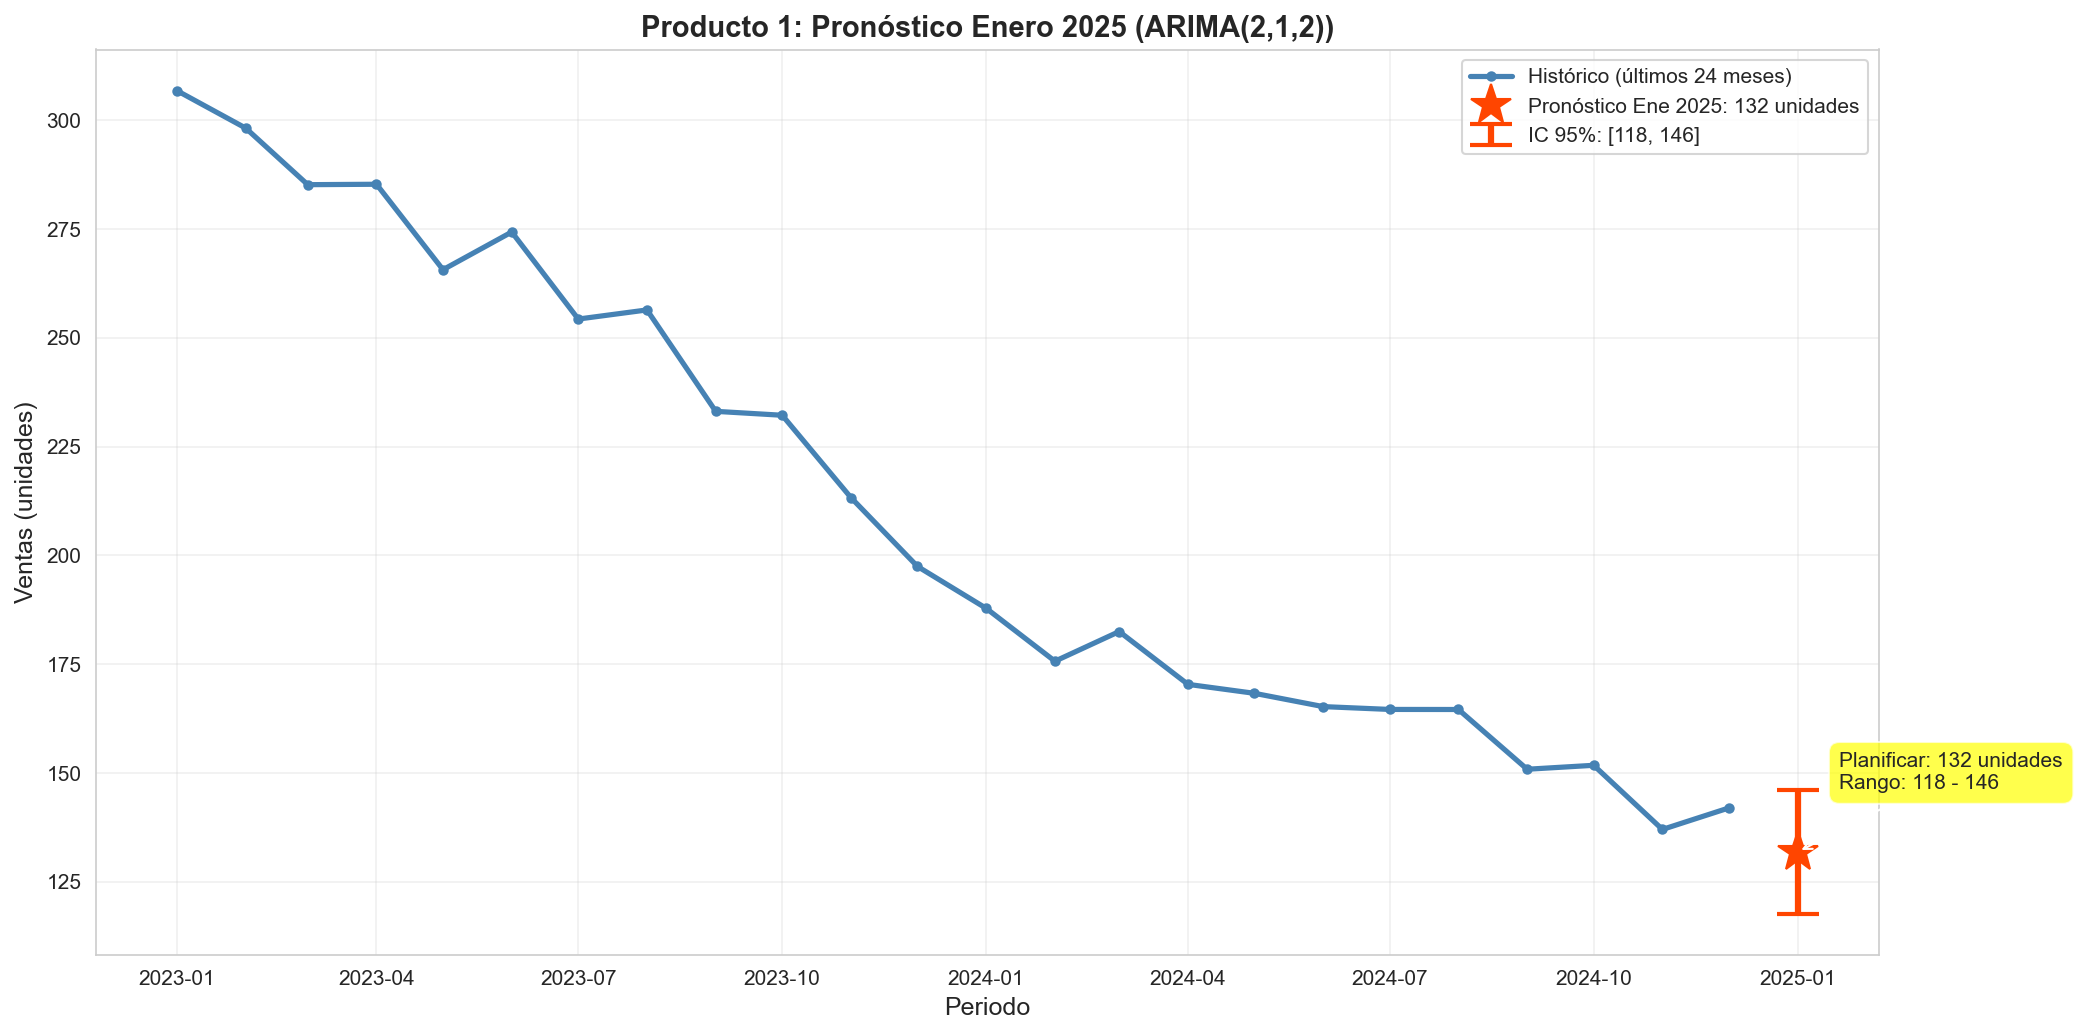

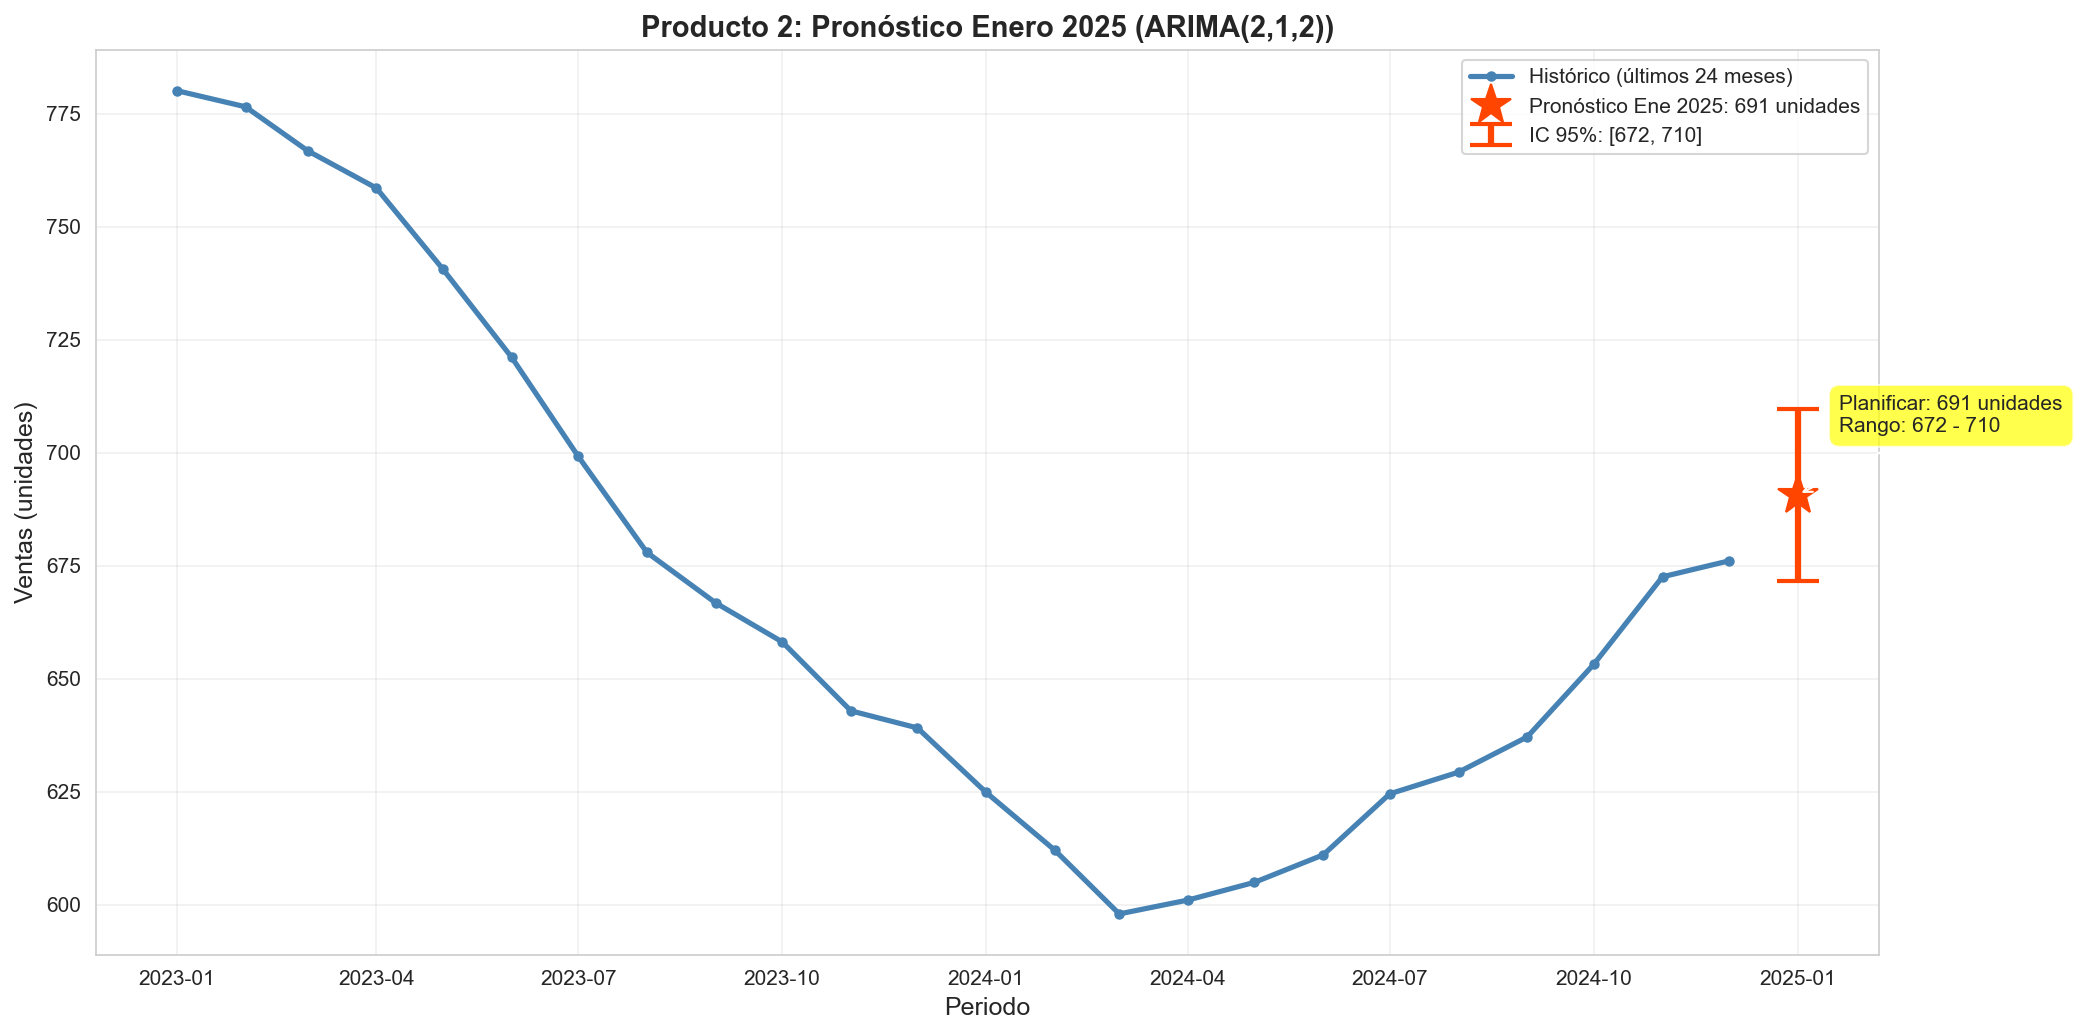

✓ Figuras 12-13 guardadas: pronósticos finales con IC (ARIMA)


In [26]:
# Figura 12: Pronóstico Producto 1
plot_final_forecast_ci(df['producto1'], p1_mean, p1_lower, p1_upper,
                       forecast_date, 'ARIMA(2,1,2)',
                       'Producto 1', 'fig12_pronostico_final_p1.png')

# Figura 13: Pronóstico Producto 2
plot_final_forecast_ci(df['producto2'], p2_mean, p2_lower, p2_upper,
                       forecast_date, 'ARIMA(2,1,2)',
                       'Producto 2', 'fig13_pronostico_final_p2.png')

print("✓ Figuras 12-13 guardadas: pronósticos finales con IC (ARIMA)")

## 7. RECOMENDACIONES DE NEGOCIO Y CONCLUSIONES

### 7.1 Recomendaciones Específicas por Producto

#### **Producto 1 (Tendencia Decreciente)**

In [27]:
# Los valores ya fueron extraídos en la celda anterior
# Usar p1_mean, p1_lower, p1_upper

print("="*60)
print("PRODUCTO 1: RECOMENDACIONES")
print("="*60)
print(f"\n📊 PRONÓSTICO ENERO 2025 (ARIMA(2,1,2)):")
print(f"  • Valor esperado: {p1_mean:.0f} unidades")
print(f"  • Intervalo confianza 95%: [{p1_lower:.0f}, {p1_upper:.0f}] unidades")
print(f"  • Amplitud del IC: {p1_upper - p1_lower:.0f} unidades")

print(f"\n💼 RECOMENDACIONES OPERATIVAS:")
print(f"  1. INVENTARIO: Planificar orden conservadora de {p1_lower:.0f}-{(p1_lower+p1_mean)/2:.0f} unidades")
print(f"     → Priorizar liquidación de stock existente")
print(f"     → Alto riesgo de obsolescencia")
print(f"\n  2. PRODUCCIÓN: Reducir capacidad asignada")
print(f"     → La tendencia decreciente es sostenida (R²=0.76)")
print(f"     → Evaluar descontinuación gradual")
print(f"\n  3. ESTRATEGIA: Implementar plan de 'cosecha'")
print(f"     → Minimizar costos operativos")
print(f"     → Maximizar rentabilidad residual")
print(f"     → Considerar sustitución por producto nuevo")

PRODUCTO 1: RECOMENDACIONES

📊 PRONÓSTICO ENERO 2025 (ARIMA(2,1,2)):
  • Valor esperado: 132 unidades
  • Intervalo confianza 95%: [118, 146] unidades
  • Amplitud del IC: 28 unidades

💼 RECOMENDACIONES OPERATIVAS:
  1. INVENTARIO: Planificar orden conservadora de 118-125 unidades
     → Priorizar liquidación de stock existente
     → Alto riesgo de obsolescencia

  2. PRODUCCIÓN: Reducir capacidad asignada
     → La tendencia decreciente es sostenida (R²=0.76)
     → Evaluar descontinuación gradual

  3. ESTRATEGIA: Implementar plan de 'cosecha'
     → Minimizar costos operativos
     → Maximizar rentabilidad residual
     → Considerar sustitución por producto nuevo


#### **Producto 2 (Crecimiento con Saturación)**

In [28]:
# Usar p2_mean, p2_lower, p2_upper (ya calculados)

print("="*60)
print("PRODUCTO 2: RECOMENDACIONES")
print("="*60)
print(f"\n📊 PRONÓSTICO ENERO 2025 (ARIMA(2,1,2)):")
print(f"  • Valor esperado: {p2_mean:.0f} unidades")
print(f"  • Intervalo confianza 95%: [{p2_lower:.0f}, {p2_upper:.0f}] unidades")
print(f"  • Amplitud del IC: {p2_upper - p2_lower:.0f} unidades")

print(f"\n💼 RECOMENDACIONES OPERATIVAS:")
print(f"  1. INVENTARIO: Planificar orden de {p2_mean:.0f} unidades")
print(f"     → Stock de seguridad hasta {p2_upper:.0f} unidades")
print(f"     → Evitar quiebres de stock (costosos en productos premium)")
print(f"\n  2. PRODUCCIÓN: Mantener capacidad actual")
print(f"     → Mercado en fase de saturación (estabilizado ~{p2_mean:.0f})")
print(f"     → Monitorear competencia y share de mercado")
print(f"\n  3. ESTRATEGIA: Momento crítico para innovación")
print(f"     → Desarrollar extensiones de línea (sabores, tamaños)")
print(f"     → Planear lanzamiento de producto sucesor (P3)")
print(f"     → Mantener inversión en marketing para defender posición")

PRODUCTO 2: RECOMENDACIONES

📊 PRONÓSTICO ENERO 2025 (ARIMA(2,1,2)):
  • Valor esperado: 691 unidades
  • Intervalo confianza 95%: [672, 710] unidades
  • Amplitud del IC: 38 unidades

💼 RECOMENDACIONES OPERATIVAS:
  1. INVENTARIO: Planificar orden de 691 unidades
     → Stock de seguridad hasta 710 unidades
     → Evitar quiebres de stock (costosos en productos premium)

  2. PRODUCCIÓN: Mantener capacidad actual
     → Mercado en fase de saturación (estabilizado ~691)
     → Monitorear competencia y share de mercado

  3. ESTRATEGIA: Momento crítico para innovación
     → Desarrollar extensiones de línea (sabores, tamaños)
     → Planear lanzamiento de producto sucesor (P3)
     → Mantener inversión en marketing para defender posición


### 7.3 Conclusiones Finales

Este análisis ha aplicado una metodología rigurosa de pronóstico de series temporales que incluye:

✅ **Análisis Exploratorio Exhaustivo**: Identificación de tendencias, estacionalidad y patrones  
✅ **Protocolo de Validación Robusto**: Ventana recursiva que simula operación real  
✅ **Comparación de Múltiples Modelos**: Evaluación de 8 modelos (MA, ETS, ARIMA)  
✅ **Optimización Bayesiana**: Ajuste automático de hiperparámetros con Optuna  
✅ **Diagnóstico de Residuales**: Validación de calidad de modelos  
✅ **Intervalos de Confianza**: Cuantificación de incertidumbre  

**Modelos Evaluados (8 por producto):**
1. Media Móvil (k=3, 5, 7)
2. SES (Simple Exponential Smoothing)
3. Holt (Tendencia Lineal)
4. Holt-Winters (Tendencia + Estacionalidad)
5. ARIMA(1,1,1)
6. **ARIMA(2,1,2)** ⭐ **MEJOR MODELO** - Usado para pronóstico
7. ARIMA(1,1,2)
8. ETS Optuna

**Modelo Final Seleccionado:**
- **ARIMA(2, 1, 2)** para ambos productos
- Seleccionado por mejor RMSE en validación recursiva
- Captura tendencia y componente autorregresivo/media móvil
- Genera pronósticos robustos con intervalos de confianza 95%

In [29]:
print("="*60)
print("MODELOS FINALES SELECCIONADOS")
print("="*60)

print(f"\nProducto 1:")
print(f"  Modelo: ARIMA(2, 1, 2)")
print(f"  Configuración: order=(2, 1, 2)")
print(f"  RMSE en validación: {results['p1']['ARIMA(2, 1, 2)']['RMSE']:.2f}")
print(f"  MAE en validación: {results['p1']['ARIMA(2, 1, 2)']['MAE']:.2f}")

print(f"\nProducto 2:")
print(f"  Modelo: ARIMA(2, 1, 2)")
print(f"  Configuración: order=(2, 1, 2)")
print(f"  RMSE en validación: {results['p2']['ARIMA(2, 1, 2)']['RMSE']:.2f}")
print(f"  MAE en validación: {results['p2']['ARIMA(2, 1, 2)']['MAE']:.2f}")

print(f"\n{'='*60}")
print("RESUMEN DE PRONÓSTICOS - ENERO 2025")
print("="*60)
print(f"\nProducto 1: {p1_mean:.0f} unidades (IC 95%: [{p1_lower:.0f}, {p1_upper:.0f}])")
print(f"Producto 2: {p2_mean:.0f} unidades (IC 95%: [{p2_lower:.0f}, {p2_upper:.0f}])")

print(f"\n{'='*60}")
print("✓ Análisis completado exitosamente")
print("✓ Todas las figuras guardadas en outputs/")
print("✓ Pronósticos generados con ARIMA(2,1,2)")
print("="*60)

MODELOS FINALES SELECCIONADOS

Producto 1:
  Modelo: ARIMA(2, 1, 2)
  Configuración: order=(2, 1, 2)
  RMSE en validación: 7.84
  MAE en validación: 6.13

Producto 2:
  Modelo: ARIMA(2, 1, 2)
  Configuración: order=(2, 1, 2)
  RMSE en validación: 9.29
  MAE en validación: 8.12

RESUMEN DE PRONÓSTICOS - ENERO 2025

Producto 1: 132 unidades (IC 95%: [118, 146])
Producto 2: 691 unidades (IC 95%: [672, 710])

✓ Análisis completado exitosamente
✓ Todas las figuras guardadas en outputs/
✓ Pronósticos generados con ARIMA(2,1,2)


---

### 📝 Notas Finales

**Para el negocio:**
Los pronósticos proporcionan una base cuantitativa sólida para decisiones de:
- Planificación de inventario
- Asignación de recursos de producción
- Estrategia de portafolio de productos